# The capsizing of Vasa - A numerical adventure

**Abstract**

In this project we will study behaviors of swedish historical ship Vasa. We will be using numerical methods with different order of accuracy to plot the oscillation of the ship and examine their respective error. We will also study the impact of some factors and visualize the process through animation.

In [161]:
import numpy as np
import matplotlib.pyplot as plt
import time as time

from IPython.display import Image
from scipy.constants import g
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema

**Describing the system**

Fluid mechanics in general is to complex to study so we will be simplify quite alot. First we will be looking at a 2 dimensional plane, meaning only a cross section of the boat will be of interest. Moreover, the structure body will be assumed a semicircle facing down towards the water. Moreover, the ship is assumed compact, with a constant mass density(mass per area in a 2 dimensional plane). 

In [162]:
Image(url= "https://i.imgur.com/Rb3B7r9.png", width=400, height=400)

This is a schematic representation of the model being used in this project. The topmost sketch shows the ship at equilibrium, while the bottommost plot shows the boat after the angular displacement $\theta$. The drawings shows the most important variables used during this project, i.e. $\beta$, $\theta$, $\gamma$, $R$, and $C$.

The central angle $\gamma$ is subtended by the arc of the semicircle submerged in the sea, and is defined as follows:

$$\gamma = 2 \arccos\left[\cos \frac{\beta}{2} - \frac{4}{3\pi}(1 - \cos\theta) + \frac{\Delta y_c}{R}\right]$$

The angle $\beta$ is defined as this central angle $\gamma$ at equilibrium. Furthermore, the vertical placement of the center of mass, $C$, is used quite alot in this project. 

Finaly, the quantity of most interest is the angular displacement of Vasa, which is represented by $\theta$ in the above drawing. This is the quantity which will be studied in the upcoming part of this project.

**Setting up the first ODE's**

Assume first gravity and buoyancy to be the only forces. With some elementary geomerty one can derive the torque to be $\tau_B = -mgh \sin(\theta)$. By newton's second law:

\begin{aligned}
    \sum \tau &= I \frac{d^2 \theta}{dt^2}\\
    \tau_B &= I_C \frac{d^2 \theta}{dt^2}\\
    -mgh \sin(\theta) &= I_C \frac{d^2 \theta}{dt^2}
\end{aligned}

For small angular displacements, we can use $\sin(\theta) \simeq \theta$ to simplify even further.

$$-mgh \theta = I_C\frac{d^2 \theta}{dt^2}$$

**Constants**

In [163]:
sigma_0 = 1000              #density water
sigma = 500                 #density ship

R = 10                      #Radius of ship
A_s = 1/2 * np.pi * R**2    #Area of ship
m = A_s * sigma             #Mass of ship

I_C = 1/2 * m * R**2 * (1 - 32 / (9 * np.pi**2))        #Moment of inertia about C

h = 4 * R / (3 * np.pi)     #distance from M to C

omega_prime = np.sqrt(m * g * h / I_C)

def getA(gamma):               #Area of immersed object
    return 1/2 * R**2 * (gamma - np.sin(gamma))
    

**Deriving fixed point $\beta$ by fixed-point iteration**

$\beta$ is given by the following equation:

\begin{aligned}
    \beta - \sin{\beta} = \pi \frac{\sigma}{\sigma_0}
\end{aligned}

The following code block is using fixed-point iteration to derive the central angle $\beta$. We are using fixed-point iteration to determine where the unique fixed point of $f(x) = \sin(x) + \frac{\pi}{2} = x$. We will comment below why fixedpoint iteration will converges and why it is unique.

In [164]:
#task 1 a)
def gBeta(beta):                    #The equation used in the fixed-point iteration
    return np.pi * sigma / sigma_0 + np.sin(beta)

def fixedpoint(g, beta0 = np.pi / 2, tol=1.e-8, max_iter=1000):

    beta = beta0

    for k in range(max_iter):        
        beta_old = beta                        # Store old values for error estimation 
        beta = g(beta)                         # The iteration
        err = abs(beta-beta_old)               # Error estimate
       

        if err < tol:                          # The solution is accepted 
            break

    return beta, k+1

beta, numberOfSteps = fixedpoint(gBeta)

print(f"beta = {np.degrees(beta):14.10f} deg = {beta} rad")

def getGamma(theta, del_yc, beta = beta):       #Function returning central angle gamma as function of beta, theta and del_yc
    return 2 * np.arccos(np.cos(beta/2) - 4/(3*np.pi) * (1 - np.cos(theta)) + del_yc/R)

beta = 132.3464590307 deg = 2.309881463441468 rad


#### **Why it converges**

While using the "fix point theorem" there might be mulitple ways to solve for $x$. Sometimes, iterating with a given expresseion might diverge, or converge for just some values. We need some kind of assurance that our will converge for all values. We will introduce the term contraction. Which is a Lipschitz continous function where the Lipschitz constant is in $[0,1)$. It is ideal to have a contraction on a complete space since "Bannach fixed point theorem" guarantees a unique fixed point which can be reached by applying $f$ on itself many times. Without justification we claim $\mathbb{R}$ to be complete. Our equation will be $\beta = \frac{\pi}{2} + \sin(\beta)$, meaning $f(x) = \frac{\pi}{2} + \sin(x)$ will be our test function. Proving $f$ a contraction is a difficult task indeed, atleast if we assume $\beta \in [0,\pi]$, so we will be using some other tricks.


Let $f^n(x) = f(f(...f(x)))$ be a contraction on a complete space. By Bannach fixed point theorem it has a unique fix point$x^*$. Moreover, applying $f$ to both sides gives 

\begin{aligned}
    f^n(x^*) &= x^*\\
    f(f^n(x^*)) &= f(x^*)\\
    f^n(f(x^*)) &= f(x^*)\\
\end{aligned}

Which shows $f(x^*)$ also a fixed point. By uniqueness of the fixed point in $f^n$ we immediatly achive $f(x^*)=x^*$ meaning it has a fixed point. Moreover we claim this point unique. Assume another fixed point $f(\tilde x) = \tilde x$. Applying $f$ $n-1$ times gives

$$f^n(\tilde x) = f^{n-1}(f(\tilde x)) = f^{n-1}(\tilde x)=...=\tilde x$$

Meaning it will be a fix point in $f^n$ aswell. But $f^n$ has exactly one such fixed point yielding $\tilde x = x^*$

In addition, the same iteration will work. 

$$\lim_{m \to \infty} f^m (x) = \lim_{k \to \infty} \big(f^{n}\big)^k (x)$$

And by assumption, $f^n$ will converge for all $x$, implying $f$ to also do so. 

$\quad \square$



In our case, it is sufficient to show $f^2(x) = f(f(x)) = \sin\bigg(\sin(x)+\frac{\pi}{2}\bigg) + \frac{\pi}{2} = \cos(\sin(x))+\frac{\pi}{2}$ a contraction.

Fix $x,y \in \mathbb{R}$. Then


\begin{align*}
    |f^2(x)-f^2(y)| &= |\text{cos}(\text{sin}(x))+\frac{\pi}{2} - \text{cos}(\text{sin}(y)) - \frac{\pi}{2}| \\
    &\leq |\text{cos}(\text{sin}(x)) - \text{cos}(\text{sin}(y))|
\end{align*}

We will now apply mean value theorem twice. since $x,y$ is fixed, $\sin(x), \sin(y)$ will just be values.


\begin{align*}
    |\text{cos}(\text{sin}(x)) - \text{cos}(\text{sin}(y))| &= |\text{cos}'(a)||\text{sin}(x)-\text{sin}(y)| \\
    &= |-\text{sin}(a)||\text{sin}'(b)||x-y| \\
    &= |\text{sin}(a)||\text{cos}(b)||x-y| \\
\end{align*}

Where $a \in \sin(\mathbb{R})=[-1,1]$ and $b\in \mathbb{R}$

Obviously $|\cos(b)|\leq 1$, but more importantly, $|\sin(a)|\leq \sin(1)<1$. 

\begin{aligned}
    |\text{sin}(a)||\text{cos}(b)||x-y| \leq \sin(1) \cdot 1 \cdot |x-y| < |x-y|
\end{aligned}

Proving $f^2$ lipscitz continous with $C = \sin(1)$ concluding $f^2$ a contraction. By our earlier remarks, $lim_{n \to \infty} f^n$ will converge. 

$\quad \square$

**Height of M, C, B and D at equilibrium**

Using the following equations, we are able to determan the initial positions of the four points M, C, B, and D, from the sketch in the introduction:

\begin{aligned}
y_{M} &=R \cos \beta / 2+(4 R / 3 \pi)(\cos \theta-1)+\Delta y_{C} \\
y_{C} &=R \cos \beta / 2-4 R / 3 \pi+\Delta y_{C} \\
y_{D} &=R \cos \beta / 2-R+(4 R / 3 \pi)(\cos \theta-1)+\Delta y_{C} 
\end{aligned}
\begin{aligned}
y_{B}^{0}=y_{M}^{0}-Y_{M B}^{0}&=R \cos \beta / 2-4 R \sin ^{3}(\beta / 2) / 3(\beta-\sin \beta) \\
Y_{M B}&=R \cdot \frac{4 \sin ^{3} \gamma / 2}{3(\gamma-\sin \gamma)}
\end{aligned}

These equations have been used in the following code blocks to determan the positions at equilibrium.

In [165]:
##Required equations

def getYm(theta, del_yc, beta = beta):                                                  #Function returning hight of meta center as function of theta, beta, del_yc
    return R * np.cos(beta/2) + (4*R/(3*np.pi)) * (np.cos(theta) - 1) + del_yc

def getYc(theta, del_yc, beta = beta):                                                  #Function returning hight of center of mass as function of theta, beta, del_yc
    return R * np.cos(beta/2) - 4*R/(3*np.pi) + del_yc

def getYd(theta, del_yc, beta = beta):                                                  #Function returning location of Vasa´s lowest point as function of theta, beta, del_yc
    return R * np.cos(beta/2) - R + 4*R/(3*np.pi) * (np.cos(theta) - 1) + del_yc

def getYMB(gamma):                                                                      #Function returning distance from meta center of Vasa to center of mass og supressed water 
    return R * 4 * np.sin(gamma/2)**3 / (3 * (gamma - np.sin(gamma)))                   #as function of theta, beta, del_yc

At equilibrium the following conditions are fullfilled: 
\begin{aligned}
\Delta y_C &= 0 \\
\theta &= 0 \\
\gamma &= \beta
\end{aligned}

In [166]:
#Getting locations of the M, C, D, B at equilibrium
ym_0 = getYm(0, 0)                  
yc_0 = getYc(0, 0)
yd_0 = getYd(0, 0)

yb_0 = ym_0 - getYMB(beta)

print(f'y_m0 = {ym_0}')
print(f'yc_0 = {yc_0}')
print(f'yb_0 = {yb_0}')
print(f'yd_0 = {yd_0}')

y_m0 = 4.039727517300396
yc_0 = -0.20440429848347907
yb_0 = -2.457918509858019
yd_0 = -5.960272482699604


**Dynamics of Vasa when movement of C is negligable**

Whilst the movement of the center of mass is viewd as negligable, the dynamics of Vasa is described in its entirety by the following equation:

\begin{aligned}
\sum \tau=I_{C} \frac{\mathrm{d} \omega}{\mathrm{d} t}
\end{aligned}

In the begining part of this project we assume the amount of immersed object to stay constant whilst Vasa is moving, i.e $A \rightarrow A_0$. Furthermore we assume there to be no forces other than gravity and bouyancy. 

From these assumtions we get the following forces to be the only ones effecting the movements of Vasa:

\begin{aligned}
&F_{G}=-m g(y) \\
&F_{B}=A \sigma_{0} g(y)
\end{aligned}

Furthermore: 

\begin{aligned}
A = A_0 \implies \lvert F_G \rvert = \lvert F_B \rvert
\end{aligned}

This further implies torque from $F_B$ to be the only torque responsible for the movement of Vasa. Therefore we get:

\begin{aligned}
\sum \tau = \tau_{B}=-F_{B} h \sin \theta=I_{C} \frac{\mathrm{d} \omega}{\mathrm{d} t}=I_{C} \frac{\mathrm{d^2} \theta}{\mathrm{d} t^2}
\end{aligned}

In [167]:
#Forces

F_G = -m * g                        #Gravity 
F_B = getA(beta) * sigma_0 * g      #Buoyancy

**Solving ODE by Eulers Method**

To solve the above ODE by Eulers Method, we will like to introduce the following vector: 

\begin{aligned}
\vec{w}(t)&=\left[\begin{array}{ll}\theta(t) & \omega(t)\end{array}\right]^{T} \\
\omega(t)&=\frac{\mathrm{d} \theta}{\mathrm{d}t}
\end{aligned}

From this we can rewrite our ODE to the following:

\begin{aligned}
\frac{\mathrm{d} \vec{w}}{\mathrm{~d} t}=\vec{f}(t, \vec{w}),
\end{aligned}

for a specific vector function $\vec{f}(t, \vec{w})$. The function $\vec{f}(t, \vec{w})$ is dependent on which forces we include in our modeling of Vasa.

By the conditions given above $\vec{f}(t, \vec{w})$ can be rewritten in the following way:

\begin{aligned}
\frac{\mathrm{d} \vec{w}}{\mathrm{d} t}(t)&=\left[\begin{array}{ll}\omega(t) & \frac{\mathrm{d} \omega}{\mathrm{d} t}(t)\end{array}\right]^{T} \\
\end{aligned}

\begin{aligned}
\tau_{B}&=-F_{B} h \sin \theta=I_{C} \frac{\mathrm{d} \omega}{\mathrm{d} t} \implies \frac{\mathrm{d} \omega}{\mathrm{d} t}(t) = -\frac{F_{B}}{I_{C}} h \sin \theta(t)
\end{aligned}

\begin{aligned}
\frac{\mathrm{d} \vec{w}}{\mathrm{d} t}&=\left[\begin{array}{ll}\omega(t) & -\frac{F_{B}}{I_{C}} h \sin \theta(t)\end{array}\right]^{T}
\end{aligned}

In [168]:
def f(t, omega_vec):                                    #Specific vector function 
    return np.array([omega_vec[1], -F_B / I_C * h * np.sin(omega_vec[0])])

**Euler's method**

Euler's method is a first order numerical method to aprroximate a function in a closed domain $[x_0, x_{end}]$

linearization of a function $y$ around $x^*$ is given by

$$y(x) \simeq  y(x^*) + x y'(x^*)$$

If the function $y$ is continous, the linearization is a good approximation when close to $x^*$, in other words $| x^* - x |$ small. Therefore, at each linearization we will only move a small step $s$ at the time before calculating a new linearization. Euler's method assumes the derivative piecewise constant giving;

$$
    y_{n+1} - y_n = h y'(x_n)
$$

With $y'(x) = f(x,y(x))$ we get the iteration formula

\begin{aligned}
    x_{n+1} &= x_n + h \\
    y_{n+1} &= y_n + h f(x_n, y_n)
\end{aligned}

Which is precisely euler's method. Note that we need an input for both $x_0, y_0$ and a formula for the derivative.

It can be shown that the global error is less than $Ch$, where  $C$ a constant and $h$ the step length, making it a first order method.

It's easy to implement euler's method in our case since we have a clear interval of interest, conditions $[\theta_0, \omega_0]$ and a straightforward formula to calulate the derivatives. 

Our implementation of eulers method is presented below, along side the solution to the given ODE

In [169]:
def euler(f, t, omega_vec, s):
    # One step of the Euler method
    omega_vec_next = omega_vec + s * f(t, omega_vec)
    t_next = t + s
    return t_next, omega_vec_next
    
def ode_solver(f, t0, tend, omega_vec_0, s, method = euler, sinking = False, load = False, fence = False):
    #Initializing:
    omega_vec_num = np.array([omega_vec_0])    # Array for the solution of omega_vec 
    t_num = np.array([t0])                     # Array for the t-values

    tn = t0                                    # Running values for t and array of omega_vec
    omega_vec_n = omega_vec_0 

    # Main loop
    while tn < tend:# - 1.e-10:                  # Buffer for truncation errors  
        if tn + s > tend:
            s = tend - tn

        if sinking == True:
            if isSinking(omega_vec_n) == False:
                tn, omega_vec_n = method(f, tn, omega_vec_n, s)     #Do one step by the given methode#
                    
                # Extend the arrays for t and omega_vec
                omega_vec_num = np.concatenate((omega_vec_num, np.array([omega_vec_n])))
                t_num = np.append(t_num,tn)


            elif isSinking(omega_vec_n) == True:                                        #Setting abs(theta) = pi/2
                if load == True:
                    omega_vec_n = [np.sign(omega_vec_n[0]) * np.pi/2, 0, 0, 0, 0, 0, omega_vec_n[6], 0]     
                else:
                    omega_vec_n = [np.sign(omega_vec_n[0]) * np.pi/2, 0, 0, 0, 0, 0]
                    
                omega_vec_num = np.concatenate((omega_vec_num, np.array([omega_vec_n])))
                tn = tn + s
                t_num = np.append(t_num,tn)
            
            if load == True and fence == False:                                         #Making sure Vasa is no longer affected by the cargo, when the cargo has left the ship
                if abs(omega_vec_n[6]) > R:
                    global cargo 
                    global m_l
                    cargo = False
                    m_l = 0
                    time = tn
            
            if load == True and fence == True:                                          #Making sure cargo is not leaving the sticky fences
                if abs(omega_vec_n[6]) > R:
                    global Cargo
                    cargo = False
                    time = tn
                    
        else:
            tn, omega_vec_n = method(f, tn, omega_vec_n, s)    # Do one step by the given methode
            
            # Extend the arrays for t and omega_vec
            omega_vec_num = np.concatenate((omega_vec_num, np.array([omega_vec_n])))
            t_num = np.append(t_num,tn)
        
    return t_num, omega_vec_num

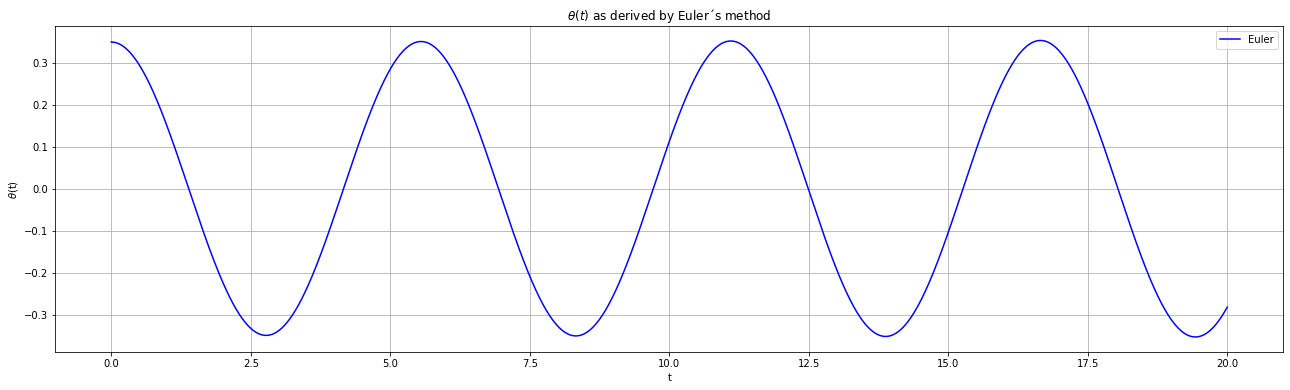

In [170]:
##Initial conditions
theta_0 = np.radians(20)     
omega_0 = 0

t_0 = 0
t_end = 20
s = 0.001

t_euler, omega_vec_euler = ode_solver(f, t_0, t_end, np.array([theta_0, omega_0]), s, euler)

# Plot of the numerical solution
plt.figure(figsize = (22,6))

plt.title(r'$\theta(t)$ as derived by Euler´s method')
plt.plot(t_euler, np.transpose(omega_vec_euler)[0], 'b-')

plt.grid()

plt.xlabel('t')
plt.ylabel(r'$\theta$(t)')
plt.legend(['Euler'])

plt.show()  

From the differnetial equation, we are expected some kind of harmonic $\sin$ or $\cos$ function, which we have achived. The amplitude is constant, as far as the naked eye can see. Our euler seems to work just fine.

0.0034918971101702834
0.004130756092830756


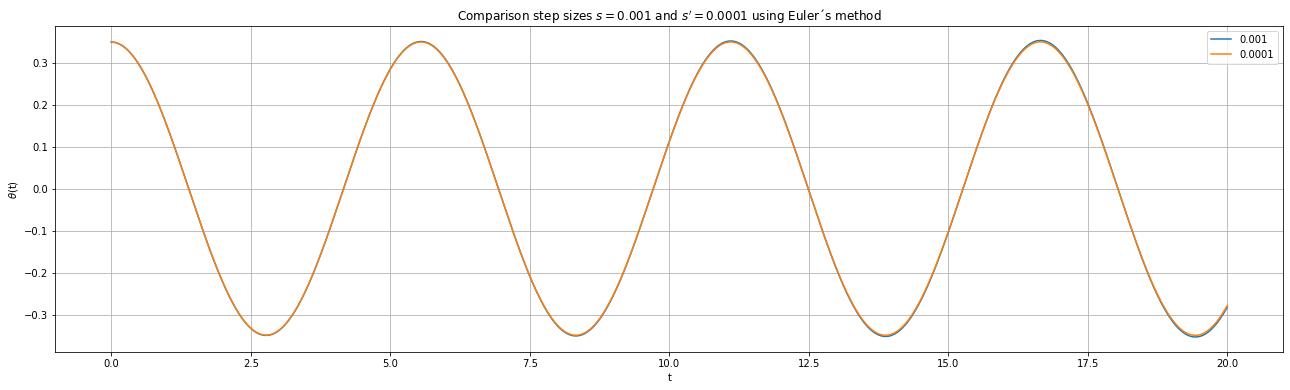

In [171]:
s = 0.0001

t_eulerA, omega_vec_eulerA = ode_solver(f, t_0, t_end, np.array([theta_0, omega_0]), s, euler)          #Euler´s method with step size 0.0001

print(abs(np.amax(omega_vec_euler)-np.amax(omega_vec_eulerA)))
print(abs(np.amin(omega_vec_euler)-np.amin(omega_vec_eulerA))) 

#Compairing euler´s method with step size s = 0.001 and s = 0.0001 
plt.figure(figsize = (22,6))

plt.title(r'Comparison step sizes $s= 0.001$ and $s^{\prime} = 0.0001$ using Euler´s method')
plt.plot(t_euler, np.transpose(omega_vec_euler)[0])
plt.plot(t_eulerA, np.transpose(omega_vec_eulerA)[0])

plt.grid()

plt.xlabel('t')
plt.ylabel(r'$\theta$(t)')
plt.legend(['0.001','0.0001'])

plt.show()

**Step length for Euler**

From the above plot, one can conclude that $0.001$ is a reasonable step length. When $s = 0.0001$ we are iterating $200000$ times total, which will give a superb estimate for the $\theta$ function. however, the graphs are almost identical in the entire interval. On some of the extreme points the graphs bearly splits. We have included the difference in the biggest and smallest value to emphasize how identical they are. These results indicate that any smaller step length value smaller than $0.001$ is unnecessary since a higher precision would give a similar graph. In our case we are using $\theta = 20^\circ$, which is relativily large. For smaller angles they will probably look even more similar, strengthening our decision.

**Small angle approximations**

For $\theta << 1$ phycisist often choose to approximate $\sin \theta \approx \theta$. In the following section we will like to comment on the validity of this approximation. To do this we need to use slightly modified version of the vector function $\vec{f}(t, \vec{w})$. We modify $\vec{f}(t, \vec{w})$ as follows:

\begin{aligned}
\vec{f}(t, \vec{w}) = \frac{\mathrm{d} \vec{w}}{\mathrm{d} t}&=\left[\begin{array}{ll}\omega(t) & -\frac{F_{B}}{I_{C}} h \theta(t)\end{array}\right]^{T}
\end{aligned}
 

In [172]:
#Modified f vector, now using the small angle approximation
def fSA(t, omega_vec):
    return np.array([omega_vec[1], -F_B / I_C * h * omega_vec[0]]) 

Before we continue this approximation we want to investigate the errors associated with it. The error is expressed as:

$$error = |\theta - \sin{\theta}|$$


The Taylor expansion about $0$ for $\sin{\theta}$ is:

$$\sin{\theta} = \theta - \frac{\theta^3}{3!} + \frac{\theta^5}{5!} - \frac{\theta^7}{7!} \cdots$$

Thus for small angles:

$$error = |\theta - \sin{\theta}| = \bigg |\frac{\theta^3}{6} - \frac{\theta^5}{120} + \frac{\theta^7}{5040} \cdots \bigg| \approx \frac{\theta^3}{6}$$

The error grows with an order of $3$. Plotting the error and different values for $\theta$:

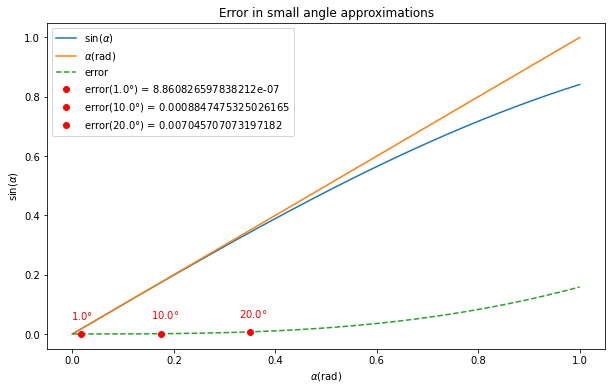

In [173]:
#plotting error in small angle approximation
alpha = np.linspace(0, 1, 1000)

plt.figure(figsize =(10,6))
plt.title("Error in small angle approximations")
plt.plot(alpha, np.sin(alpha), label=r"sin($\alpha$)")
plt.plot(alpha, alpha, label=r"$\alpha$(rad)")
plt.plot(alpha, alpha-np.sin(alpha), '--', label="error")

degrees = [1.0, 10.0, 20.0]

for deg in degrees:
    rad = np.radians(deg)
    err = round(rad-np.sin(rad),100)
    plt.plot(rad, err, 'o', label=f"error({deg}$\degree$) = {err}", color='r')
    plt.text(rad-0.02, err+0.05, f"{deg}$\degree$", color='r')

plt.xlabel(r"$\alpha$(rad)")
plt.ylabel(r"sin($\alpha$)")
plt.legend()
plt.show()

The graph ilustrates why we often can assume $\sin(\theta) = \theta$. For the smallest values, the error is close to zero, making the approxiamtion valid. Even though the error seems small for $10^\circ$ and $20^\circ$, the error in the next iteration will inherit the previous error and the global error will grow over time. We need to be somewhat careful. We will try to see how the global error develops over time. Choosing $\theta_0 = 1.0^\circ$ and $\theta_0 = 20^\circ$ with no initial velocity with and without small angle approximations(SA).

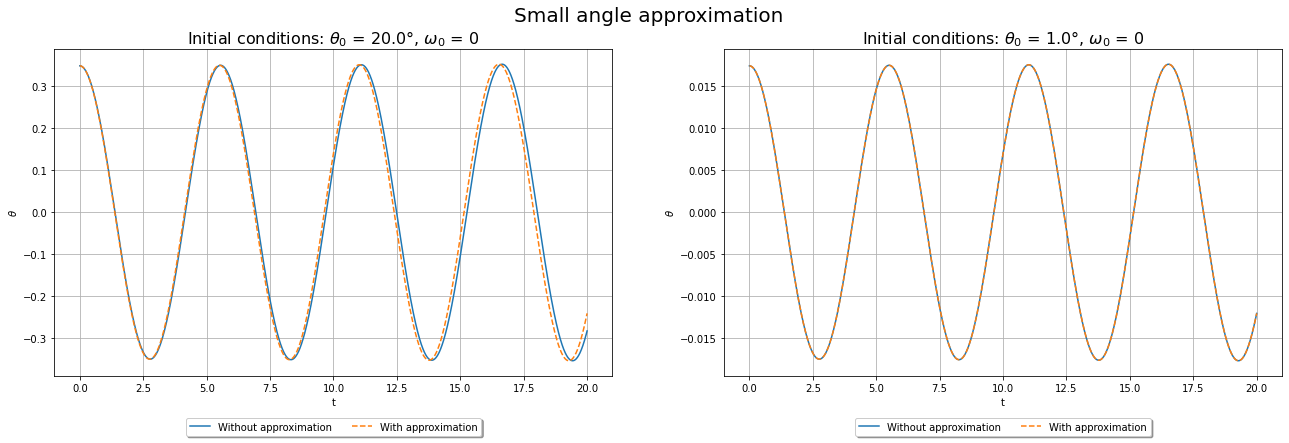

In [174]:
##Initial conditions
theta_0_a = np.radians(20)
theta_0_b = np.radians(1)     
omega_0 = 0

t_0 = 0
t_end = 20
s = 0.001

t_20, omega_vec_20 = ode_solver(f, t_0, t_end, np.array([theta_0_a, omega_0]), s)               #Euelers method without small angle approximation for theta_0 = 20 deg
t_20_SA, omega_vec_20_SA = ode_solver(fSA, t_0, t_end, np.array([theta_0_a, omega_0]), s)       #Euelers method with small angle approximation for theta_0 = 20 deg

t_1, omega_vec_1 = ode_solver(f, t_0, t_end, np.array([theta_0_b, omega_0]), s)                 #Euelers method without small angle approximation for theta_0 = 1 deg
t_1_SA, omega_vec_1_SA = ode_solver(fSA, t_0, t_end, np.array([theta_0_b, omega_0]), s)         #Euelers method without small angle approximation for theta_0 = 1 deg


fig, axs = plt.subplots(1,2, figsize = (22,6))
fig.suptitle("Small angle approximation", fontsize=20)

# Theta_0 = 20 deg
axs[0].plot(t_20, np.transpose(omega_vec_20)[0], label = "Without approximation")
axs[0].plot(t_20_SA, np.transpose(omega_vec_20_SA)[0], '--', label = "With approximation")
axs[0].set_title(r"Initial conditions: ${\theta}_0$ = "+f"{round(np.degrees(theta_0_a),4)}$\degree$"+r", ${\omega}_0$ = "+f"{omega_0}", fontsize=16)
axs[0].set_xlabel("t")
axs[0].set_ylabel(r"$\theta$")
axs[0].legend(loc = "lower center", bbox_to_anchor=(0.5, -0.2), ncol= 2, shadow = True)
axs[0].grid()

# Theta_0 = 1 deg
axs[1].plot(t_1, np.transpose(omega_vec_1)[0], label = "Without approximation")
axs[1].plot(t_1_SA, np.transpose(omega_vec_1_SA)[0], '--', label = "With approximation")
axs[1].set_title(r"Initial conditions: ${\theta}_0$ = "+f"{round(np.degrees(theta_0_b),4)}$\degree$"+r", ${\omega}_0$ = "+f"{omega_0}", fontsize=16)
axs[1].set_xlabel("t")
axs[1].set_ylabel(r"$\theta$")
axs[1].legend(loc = "lower center" , bbox_to_anchor=(0.5, -0.2), ncol= 2, shadow = True)
axs[1].grid()


There is a considerable difference for larger initial angles, and the error increases with $t$. 

To calculate the error, we will run multiple simulations with $\theta_0 = 20^\circ$ and $\theta_0 = 1^\circ$ with and without small angle approximation. We will be using supremum norm to evaluate their differances. 

$$\varepsilon_g = \max_i|{\varepsilon_g}_i|=\max_i|\theta_i - {\theta_i}_{SA}| = \|\theta - {\theta}_{SA}\|_\infty $$

in other words, we are looking through the entries and finding the largest differance. 


In addition we can obtain and confirm the order $p$ of the global error by assuming $\varepsilon_g(\theta) \approx M \theta^p$ for some $M>0$:

$$\log\bigg(\frac{\varepsilon_g(\theta_1)}{\varepsilon_g(\theta_2)}\bigg) \approx p \log\bigg(\frac{\theta_1}{\theta_2}\bigg)$$

If we choose values of $\theta_1$ and $\theta_2$ such that $\theta_1 = 10\theta_2$, the logarithmic expressen simplifies to the following:

$$\log\bigg(\frac{\varepsilon_g(\theta_1)}{\varepsilon_g(\theta_2)}\bigg) \approx p \log\bigg(\frac{10\theta_2}{\theta_2}\bigg) = p \log\left(10\right) = p$$

In our specific case, we derived the order of error to be $p = 3$. The code block below is using the correspondence derived above to check whether or not this is the case for our model.


Relative error for 1.0 degrees is 0.05%
Relative error for 10.0 degrees is 4.93%
Relative error for 20.0 degrees is 19.76%
The order of error is 3.00044


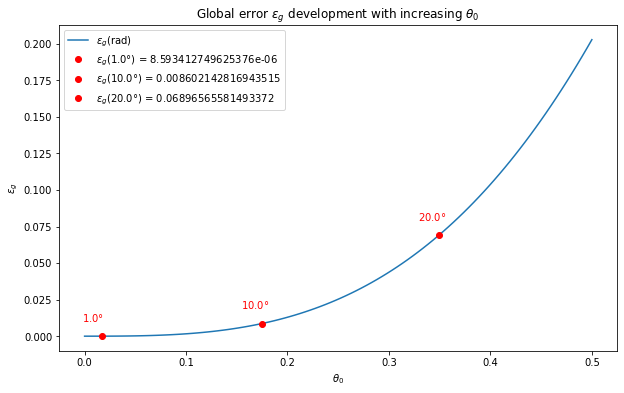

In [175]:
#Plotting global error as function of theta
theta_0_array = np.linspace(0, 0.5, 100)
omega_0 = 0

t_0 = 0
t_end = 20
s = 0.01

#Error in intervall theta_0 = [0, 0.5]
error_array = np.zeros(len(theta_0_array))
error_general_array = np.zeros(len(theta_0_array))
for i in range(len(theta_0_array)):
    t, omega_vec = ode_solver(f, t_0, t_end, np.array([theta_0_array[i], omega_0]), s)
    t_SA, omega_vec_SA = ode_solver(fSA, t_0, t_end, np.array([theta_0_array[i], omega_0]), s)
    error = np.linalg.norm(np.transpose(omega_vec)[0] - np.transpose(omega_vec_SA)[0], np.inf)
    error_array[i] = error

plt.figure(figsize =(10,6))
plt.title(r"Global error $\varepsilon_g$ development with increasing ${\theta}_0$")
plt.plot(theta_0_array, error_array, label = r"$\varepsilon_g$(rad)")

degrees = [1.0, 10.0, 20.0]
errors = []
for deg in degrees:
    rad = np.radians(deg)
    t, omega_vec = ode_solver(f, t_0, t_end, np.array([rad, omega_0]), s)
    t_SA, omega_vec_SA = ode_solver(fSA, t_0, t_end, np.array([rad, omega_0]), s)
    error = np.linalg.norm(np.transpose(omega_vec)[0] - np.transpose(omega_vec_SA)[0], np.inf)
    errors.append(error)
    plt.plot(rad, error, 'o', color = 'r', label = r"$\varepsilon_g$"+f"({deg}$\degree$) = {round(error,100)}")
    plt.text(rad-0.02, error+0.01, f"{deg}$\degree$", color='r')
    error_rel = round(error/np.linalg.norm(omega_vec[0])*100,2)
    print(f"Relative error for {deg} degrees is {error_rel}%")

print(f"The order of error is {round(np.log10(errors[1]/errors[0]),5)}")
plt.xlabel(r"${\theta}_0$")
plt.ylabel(r"$\varepsilon_g$")
plt.legend()
plt.show()

The global error with $\theta_0 = 1.0^\circ$ is considerable lower than $\theta_0 = 20.0^\circ$ with an relative error $19.76$% for $\theta_0 = 20.0^\circ$ and $0.05$% for $\theta_0 = 1.0^\circ$. In addition we confirm that the error has an order of $3$, which we derived earlier.

To conclude, it is important to use a small initial value so that the global error is minimized. We will therefore use angles less than $1^\circ$, and accept a maximum error $\varepsilon_g \le 8.59\cdot10^{-6}$ derived from the small angle approximations.


**Implementing Runge-Kutta 4 as an alternative ODE solver**

From now on we would like to use a higher order ODE solver than eulers method namely, RK4. This is a fourth order method which is wildly used due to its simple implementation. 
We are introducing the following vector quantities to further simplefy its implementation:

\begin{aligned}
\overrightarrow{k_{1}} &=\vec{f}\left(t_{i}, \overrightarrow{w_{i}}\right) \\
\overrightarrow{k_{2}} &=\vec{f}\left(t_{i}+\frac{s}{2}, \vec{w}_{i}+s \frac{\overrightarrow{k_{1}}}{2}\right) \\
\overrightarrow{k_{3}} &=\vec{f}\left(t_{i}+\frac{s}{2}, \overrightarrow{w_{i}}+s \frac{\overrightarrow{k_{2}}}{2}\right) \\
\overrightarrow{k_{4}} &=\vec{f}\left(t_{i}+s, \vec{w}_{i}+s \overrightarrow{k_{3}}\right),
\end{aligned}

By the use of these vector functions we can express $\vec{w}_{i+1}$ as follows:

\begin{aligned}
\vec{w}_{i+1}=\vec{w}_{i}+\frac{s}{6}\left(\overrightarrow{k_{1}}+2 \overrightarrow{k_{2}}+2 \overrightarrow{k_{3}}+\overrightarrow{k_{4}}\right)
\end{aligned}

In [176]:
#Implementation of RK4
def RK4(f, t, omega_vec, s):
    k1 = f(t, omega_vec)
    k2 = f(t + s/2, omega_vec + s/2 * k1)
    k3 = f(t + s/2, omega_vec + s/2 * k2)
    k4 = f(t + s, omega_vec + s * k3)
    
    omega_vec_next = omega_vec + s/6 * (k1 + 2 * k2 + 2 * k3 + k4)
    t_next = t + s

    return t_next, omega_vec_next 

**Finding analytic solution to ODE with small angle approximation**

Given

\begin{aligned}
    \theta + \alpha^2 \frac{d^2 \theta}{dt^2} = 0, \quad \quad \alpha^2 = \frac{I_C}{F_B h}, \quad \quad \theta(t_0)=\theta_0, \quad \omega(t_0) = \omega_0
\end{aligned}

We will be using Laplace transform to solve the general ODE
\begin{aligned}
    \mathcal{L} \{0\}&= \mathcal{L} \bigg \{ \theta + \alpha^2 \frac{d^2 \theta}{dt^2} \bigg \}\\
    &= \mathcal{L} \{ \theta\} + \alpha^2 \mathcal{L}\bigg \{ \frac{d^2 \theta}{dt^2} \bigg \}\\
    &= \mathcal{L} \{ \theta\} + \alpha^2 \big(s^2 \mathcal{L} \{\theta\} - s \theta(0) - \omega(0)\big) \\
    &= \mathcal{L} \{ \theta\} + \alpha^2 \big(s^2 \mathcal{L} \{\theta\} - s \theta_0 - \omega_0\big) \\
    \implies s \theta_0 + \omega_0 &=\frac{\mathcal{L}}{\alpha^2 } \{ \theta\} + s^2 \mathcal{L} \{\theta\} \\
    s \theta_0 + \omega_0 &= \bigg ( \frac{1}{\alpha^2 } + s^2 \bigg)\mathcal{L} \{\theta\} \\
     \frac{s \theta_0 + \omega_0}{\frac{1}{\alpha^2 } + s^2} &= \mathcal{L} \{\theta\} \\
     \implies \mathcal{L}\{\theta\} &= \frac{s \theta_0 + \omega_0}{\frac{1}{\alpha^2 } + s^2} \\
     \implies \theta = \mathcal{L}^{-1} \bigg\{ \frac{s \theta_0 + \omega_0}{\frac{1}{\alpha^2 } + s^2} \bigg \} &= \theta_0 \mathcal{L}^{-1} \bigg\{ \frac{s}{\frac{1}{\alpha^2 } + s^2} \bigg \} + \alpha \omega_0\mathcal{L}^{-1} \bigg\{ \frac{\frac{1}{\alpha}}{\frac{1}{\alpha^2 } + s^2} \bigg \}
\end{aligned}

Finally yielding

\begin{aligned}
    \theta(t) = \theta_0 \cos \bigg(\frac{t}{\alpha}\bigg) + \alpha \omega_0 \sin\bigg(\frac{t}{\alpha}\bigg) = \theta_0 \cos \bigg(\sqrt{\frac{F_B h}{I_C}} t \bigg) +  \omega_0 \sqrt{\frac{I_C}{F_B h}} \sin\bigg(\sqrt{\frac{F_B h}{I_C}} t\bigg)
\end{aligned}

With our initial conditions $\theta_0 = \frac{\pi}{9}, \omega_0 = 0$ we get

\begin{aligned}
    \theta(t) =  \frac{\pi}{9} \cos \bigg(\sqrt{\frac{F_B h}{I_C}}t \bigg)
\end{aligned}

In [177]:
def thetaThilde(t, theta_0, omega_0):               #Analytic solution to ODE with small angle approximation
    return theta_0 * np.cos(np.sqrt(F_B * h / I_C) * t) + omega_0 * np.sqrt(I_C/ (F_B * h)) * np.sin(np.sqrt(F_B * h / I_C) * t)

**Investigating error at $t_{end} = 20$ for step sizes $s \in \left[0.001, 0.1\right]$**

In [178]:
def error(method, s_array, t0, tend, theta_0, omega_0):     #Function returning difference between analytical value and numerical solution at t_end
    errors = np.zeros(len(s_array))

    for i in range(len(s_array)):
        t, theta = ode_solver(fSA, t0, tend, np.array([theta_0, omega_0]), s_array[i], method)
        theta_thilde = thetaThilde(tend, theta_0, omega_0)
    
        errors[i] = abs(theta_thilde - np.transpose(theta)[0][-1])

    return errors

Slope of error of eulers method: 1.2420133564870326
Slope of error of RK4 method: 3.945602804713329
Slope of error of eulers method for s in (0.001, 0.005): 1.0190747534763906


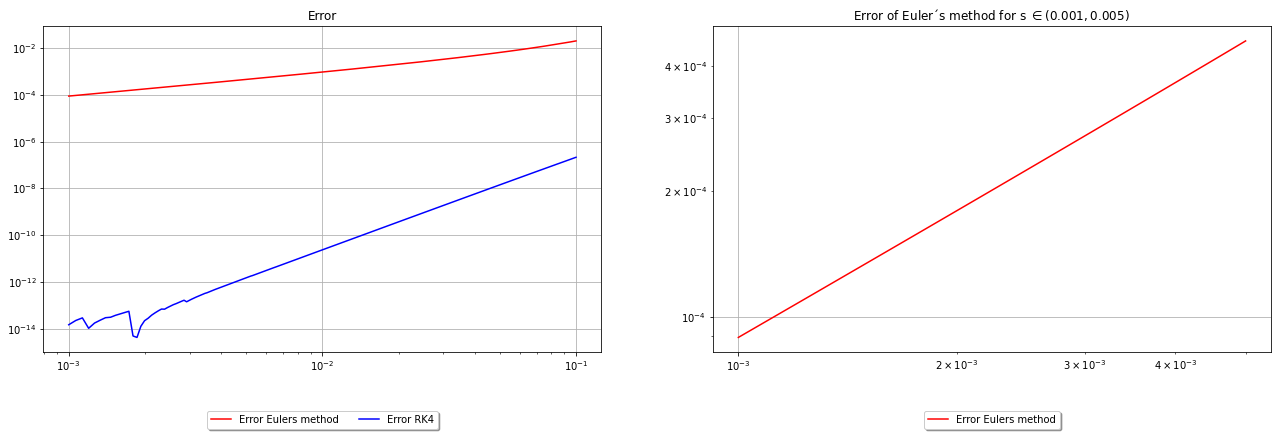

In [179]:
s_array = np.linspace(0.001, 0.1, 1500)

theta_0 = 0.01
omega_0 = 0

error_euler = error(euler, s_array, t_0, t_end, theta_0, omega_0)
error_RK4 = error(RK4, s_array, t_0, t_end, theta_0, omega_0)

s_array2 = np.linspace(0.001, 0.005, 100)
error_euler2 = error(euler, s_array2, t_0, t_end, theta_0, omega_0)

def func(x, a, b):              #Needed as input of curve_fit
    return a * x + b

#using curve_fit to find slope of logarithmic plot of error
euler_parameters, covar = curve_fit(func, np.log(s_array), np.log(error_euler))
RK4_parameters, covar = curve_fit(func, np.log(s_array), np.log(error_RK4))
euler_parameters2, covar = curve_fit(func, np.log(s_array2), np.log(error_euler2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,6))

ax1.set_title("Error")

ax1.loglog(s_array, error_euler, "r-", label = "Error Eulers method")
ax1.loglog(s_array, error_RK4, "b-", label = "Error RK4")

ax1.legend(loc = "lower center", bbox_to_anchor=(0.5, -0.25), ncol= 2, shadow = True)
ax1.grid()

ax2.set_title(r'Error of Euler´s method for s $\in (0.001, 0.005)$ ')

ax2.loglog(s_array2, error_euler2, "r-", label = "Error Eulers method")

ax2.legend(loc = "lower center", bbox_to_anchor=(0.5, -0.25), ncol= 2, shadow = True)
ax2.grid()


print(f'Slope of error of eulers method: {euler_parameters[0]}')
print(f'Slope of error of RK4 method: {RK4_parameters[0]}')
print(f'Slope of error of eulers method for s in (0.001, 0.005):', euler_parameters2[0])


We can here see the outcome of their order of accuracy $p$. Generally, the error is linear with a gradient $p$, which the graphs ilustrate. We will comment below why that is. 

For the smallest values what happens we see that the graphs deviate from the line. We believe that that computer is at fault for this one. The computer need to store information with a finite amout of bites, thus can only store spesific numbers. 

In [180]:
print(2/3 + 1/6 - 5/6)

-1.1102230246251565e-16


In the above block we see that even though this value should be $0$, the computer's rounding error make them differe. We see that the order of $-16$ cannot precisely calculated. In the ODE solver, when the step length is small, these deviation cannot be neglected. We will also keep in mind that error will propagte with every iteration. Therefore we expect some inconsistency around $10^{-16}$, and we see this around $10^{-13}$ in our graph

**Proof of error slope**

For a numerical method of order $n$, the error is big O of step length to the power of $n$. Meaning. 

$$E(s) = O(s^n) \implies E(s) \leq C_s s^n$$

where $C$ is a constant function depending on $s$, meaning it is fixed for each step length.
Taking $\log$ on each sides gives

\begin{aligned}
    \log(E(s)) &\leq \log(C_s s^n)\\
    &= \log(C_s) + \log(s^n)\\
    &= n \log(s) + \log(C_s) \\
    &= n \log(s) + C
\end{aligned}

Therefore, using $\log(s)$ as the abscissa gives a linear function with slope of $n$. We expect a somewhat linear function for the error when axis' are in a logaritmic scale. A somewhat deviate behavior might occasionally occur since it is only "bounded by" and not "equal".

**A more complex system**

From now on we will introduce further aspectes to our system describing Vasa.

We will no longer assume the area of immersed object to be constant. As a consequence the center of mass will no longer be at rest. Therefore the dynamics of Vasa is no longer described by a single equation, but rather by a system of ODE´s:

\begin{aligned}
\sum \boldsymbol{F}&=m \boldsymbol{A}=m \frac{\mathrm{d} \boldsymbol{V}}{\mathrm{d} t}=m \frac{\mathrm{d}^{2} \boldsymbol{R}}{\mathrm{d} t^{2}} \\
\sum \tau&=I_{C} \frac{\mathrm{d} \omega}{\mathrm{d} t}
\end{aligned}

To be able to use our implementation of RK4 to solve the above system, we need to further modify our vector quantity $\vec{w}(t)$ and vector function $\vec{f}(t, \vec{w})$ in the following way:

\begin{aligned}
\vec{w}(t) &= \left[\begin{array}{ll}\theta(t) & \omega(t) & x & y & v_x & v_y \end{array}\right]^{T} \\
\vec{f}(t, \vec{w})=\frac{\mathrm{d} \vec{w}}{\mathrm{d} t} &= \left[\begin{array}{ll}\omega(t) & -\frac{F_{B}}{I_{C}} h \theta(t) & v_x & v_y & a_x & a_y \end{array}\right]^{T}
\end{aligned}

We will continue to use the same set of forces as before, $F_B$ and $F_G$, but since the $A \neq A_0$, the dynamics of the system will change.

In [181]:
def getF_B(gamma):
    return getA(gamma) * sigma_0 * g

def getF_G(m_l = 0):
    return - (m + m_l) * g

def getT_B(theta, F_B):
    return -F_B * h * np.sin(theta)

In [182]:
#modified vecor function
def f2(t, omega_vec):
    gamma = getGamma(omega_vec[0], omega_vec[3] - yc_0)

    F_B = getF_B(gamma)
    F_G = getF_G()
    sumT = getT_B(omega_vec[0], F_B)
    
    d_omega = sumT / I_C

    a_x = 0
    a_y = (F_B + F_G) / m

    return np.array([omega_vec[1], d_omega, omega_vec[4], omega_vec[5], a_x, a_y])

Implementing the modified version of $\vec{f}(t, \vec{w})$ makes us able to plot how the quantity $y_C$ is behaving as a function of time.

In [183]:
##Initial conditions
theta0 = np.radians(20)
omega0 = 0
s = 0.01

t0 = 0
tend = 20

omega_vec_initial = np.array([theta0, omega0, 0, yc_0, 0, 0])

t_yc, omega_vec_yc = ode_solver(f2, t_0, t_end, omega_vec_initial, s, RK4)

gammaArray = getGamma(np.transpose(omega_vec_yc)[0], np.transpose(omega_vec_yc)[3] - yc_0)      # can be utilized to plot A(t)
AArray = getA(gammaArray)/ getA(getGamma(0 , 0))                                                                     # A(t)

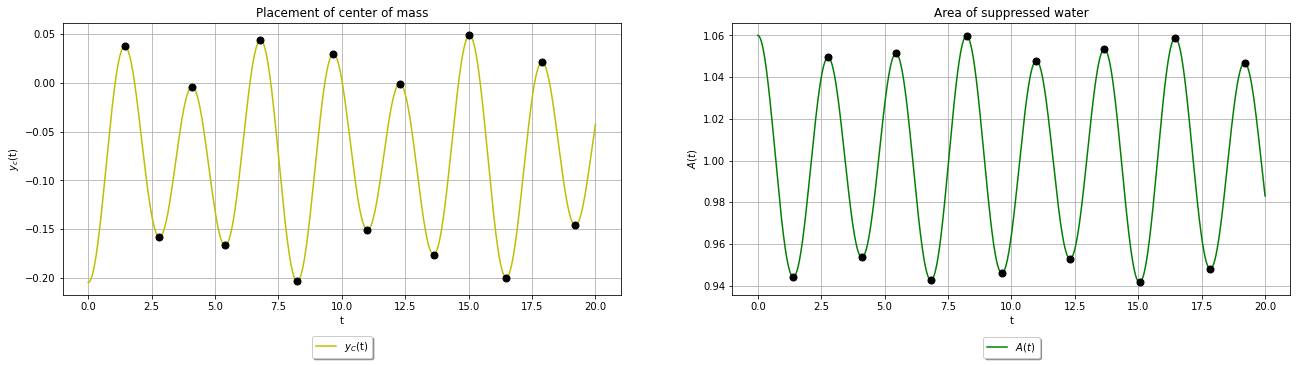

In [184]:
##Local maxima/minima for A and y_c
indicesOfMaxima_y_c = argrelextrema(np.transpose(omega_vec_yc)[3], np.greater)
valuesOfMaxima_y_c = np.transpose(omega_vec_yc)[3][indicesOfMaxima_y_c[0]]
indicesOfMaxima_A = argrelextrema(AArray, np.greater)
valuesOfMaxima_A = AArray[indicesOfMaxima_A[0]]

indicesOfMinima_y_c = argrelextrema(np.transpose(omega_vec_yc)[3], np.less)
valuesOfMinima_y_c = np.transpose(omega_vec_yc)[3][indicesOfMinima_y_c[0]]
indicesOfMinima_A = argrelextrema(AArray, np.less)
valuesOfMinima_A = AArray[indicesOfMinima_A[0]]

#Plotting y_c, A, y_c/y_c^0 and A/A_0
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (22,5))

ax1.plot(t_yc, np.transpose(omega_vec_yc)[3], 'y-', label = r'$y_C$(t)')
ax1.set_title(r'Placement of center of mass')
ax1.set_ylabel(r'$y_c$(t)')
ax1.set_xlabel(r't')
ax1.legend(loc = "lower center", bbox_to_anchor=(0.5, -0.25), ncol= 2, shadow = True)
ax1.grid()

ax2.plot(t_yc, AArray, 'g-', label = r'$A(t)$')
ax2.set_title(r'Area of suppressed water')
ax2.set_ylabel(r'$A(t)$')
ax2.set_xlabel(r't')
ax2.legend(loc = "lower center", bbox_to_anchor=(0.5, -0.25), ncol= 2, shadow = True)
ax2.grid() 

for i in range(len(indicesOfMaxima_y_c[0])):
    ax1.plot(t_yc[indicesOfMaxima_y_c[0]][i], valuesOfMaxima_y_c[i], marker = 'o', markersize = 7, markerfacecolor= 'black', markeredgecolor = 'black')
    ax1.plot(t_yc[indicesOfMinima_y_c[0]][i], valuesOfMinima_y_c[i], marker = 'o', markersize = 7, markerfacecolor= 'black', markeredgecolor = 'black')
    ax2.plot(t_yc[indicesOfMaxima_A[0]][i], valuesOfMaxima_A[i], marker = 'o', markersize = 7, markerfacecolor= 'black', markeredgecolor = 'black')
    ax2.plot(t_yc[indicesOfMinima_A[0]][i], valuesOfMinima_A[i], marker = 'o', markersize = 7, markerfacecolor= 'black', markeredgecolor = 'black')

The above plots shows the relationship between the position of the center of mass, $y_c$ and the amount of suppressed water, $A$. The rightmost plot shows the amount of suppressed water as a function of time, relative the amount of suppressed water at equilibrium. 


Clearly the amount of suppressed water is at its lowest for higher values of $y_c$. This obvious corrolation between $y_c$ and $A$ is clearly visible in the above plots. 
Moreover, it would be of interest to locate local maxima and minima for both functions and see how they corrolate. These locations are tabulated below.

In [185]:
print(f'Local minima of y_c(t): {np.round(t_yc[indicesOfMinima_y_c], 1)}')
print(f'Local maxima of A(t): {np.round(t_yc[indicesOfMaxima_A], 1)}')
print('-------------------------------------------------------------')
print(f'Local maxima of y_c(t): {np.round(t_yc[indicesOfMaxima_y_c], 1)}')
print(f'Local minima of A(t): {np.round(t_yc[indicesOfMinima_A], 1)}')

Local minima of y_c(t): [ 2.8  5.4  8.2 11.  13.6 16.5 19.2]
Local maxima of A(t): [ 2.8  5.4  8.2 11.  13.7 16.5 19.2]
-------------------------------------------------------------
Local maxima of y_c(t): [ 1.4  4.1  6.8  9.7 12.3 15.  17.9]
Local minima of A(t): [ 1.4  4.1  6.8  9.6 12.3 15.  17.8]


The above data shows how a local minima/maxima of $y_c(t)$ corresponds to a local maxima/minima of $A/A_0(t)$, which further strenghten the above analysis.

**The sinking of Vasa**

Clearly, for given values of the angle $\theta$ parts of Vasa will get submerged in the sea. The condition for the such an event is given by the following inequality:

\begin{aligned}
\theta > \frac{\pi - \gamma}{2}
\end{aligned}

In our model, we would like the first occurrence of this event to mark the sinking of Vasa. This is done in the following way:

Assume Vasa is sinking at $t_i$, we define the following:

\begin{aligned}
\vec{w}(t_j) &= \left[\begin{array}{ll}sgn(\theta_{i-1})\frac{\pi}{2} & 0 & 0 & 0 & 0 & 0 \end{array}\right]^{T}, \qquad \forall j > i 
\end{aligned}



In [186]:
#Checking if Vasa is sinking 
def isSinking(omega_vec, yc_0 = yc_0):
    gamma = getGamma(omega_vec[0], omega_vec[3] - yc_0)

    if abs(omega_vec[0]) > (np.pi - gamma)/2:                   #utalizing absolute value to assure our model capsize for both positive and negative values for theta
        return True
        
    return False

**Findig the smallest $\omega(t=0)$ that results in sinking of Vasa**

We have come to the conclusion that their exists a critical point $\omega_0^*$ such that every anglular velocity $\alpha$ such that $|\alpha| < |\omega|$ will stay afloat and $ |\alpha| > |\omega|$ will capsize ($|\omega| = |\alpha|$ may vary). Then we can use the bisection method to find this spesific point. Without justification, we claim the boat will submerge when $\omega_0 = 0.5$ so our test interval will be $[0,0.5]$. 

We give the boolean values to be $1$ if Vasa sinks, and $-1$ else. 

**Bisection**

The bisection method splits a interval into two equal parts and checks where the sign is. By assumption, there is a unique critical point, and it may be locatated to the right or left of the center point. By checking the sign of the center point, we can determine which interval it is. Since the sign of the end points must change if the critical point is inside. Recursivly we readjust our interval of interest and bisect once more. The the process repeats until the terminition condition is achived, which is when the interval is less than the input tolerance. 

In [187]:
#Implementing bisection method as described above
def bisection(omega_a, omega_b, tol=1.e-10, max_iter = 100, k = 0):
    t_a, omega_vec_a = ode_solver(f2, t0, tend, np.array([theta0, omega_a, 0, yc_0, 0, 0]), s, method = RK4, sinking = True)            #omega vector corresponding to lowest omega_0 
    t_b, omega_vec_b = ode_solver(f2, t0, tend, np.array([theta0, omega_b, 0, yc_0, 0, 0]), s, method = RK4, sinking = True)            #omega vector corresponding to highest omega_0

    #assuming Vasa don not sink for both cases 
    death_a = -1     
    death_b = -1

    #cheking for capsizing 
    if np.transpose(omega_vec_a)[-1][-1] == 0:      
        death_a = 1
    if np.transpose(omega_vec_b)[-1][-1] == 0:
        death_b = 1

    assert death_a * death_b<0, 'Error: f(a)*f(b)>0, there may be no root in the interval.'

    
    while True:
        omega_c = 1/2 * (omega_a + omega_b)                 # The midpoint

        t_c, omega_vec_c = ode_solver(f2, t0, tend, np.array([theta0, omega_c, 0, yc_0, 0, 0]), s, method = RK4, sinking = True)        #omega vector corresponding to omega_0 at midpoint  
        
        #assuming Vasa don not sink
        death_c = -1

        #cheking for capsizing 
        if np.transpose(omega_vec_c)[-1][-1] == 0:
            death_c = 1

        #returing midpoint when interval is smaller than given tolerance 
        if omega_b-omega_a < tol:     # The zero is found!
            break

        elif death_a * death_c < 0:                                  # There is a root in [omega_a, omega_c]
            return bisection(omega_a, omega_c, k = k + 1)
        else:                                                      # There is a root in [omega_c, omega_b]  
            return bisection(omega_c, omega_b, k= k + 1)

    return omega_c, k

In [188]:
#Inital conditions:
theta0 = 0
t0 = 0
tend = 20
s = 0.01

omega_intevral = [omega_a, omega_b] = [0.0, 0.5]

#utalizing bisection method to 
smallest_omega, k = bisection(omega_a, omega_b)
print(r'The smalleste omega0 resulting in sinking is', smallest_omega, 'found after', k, 'steps')


The smalleste omega0 resulting in sinking is 0.43154758130549453 found after 33 steps


In [189]:
#condition for capsizing 
def condition(theta, del_yc):
    return (np.pi - getGamma(theta, del_yc)) / 2

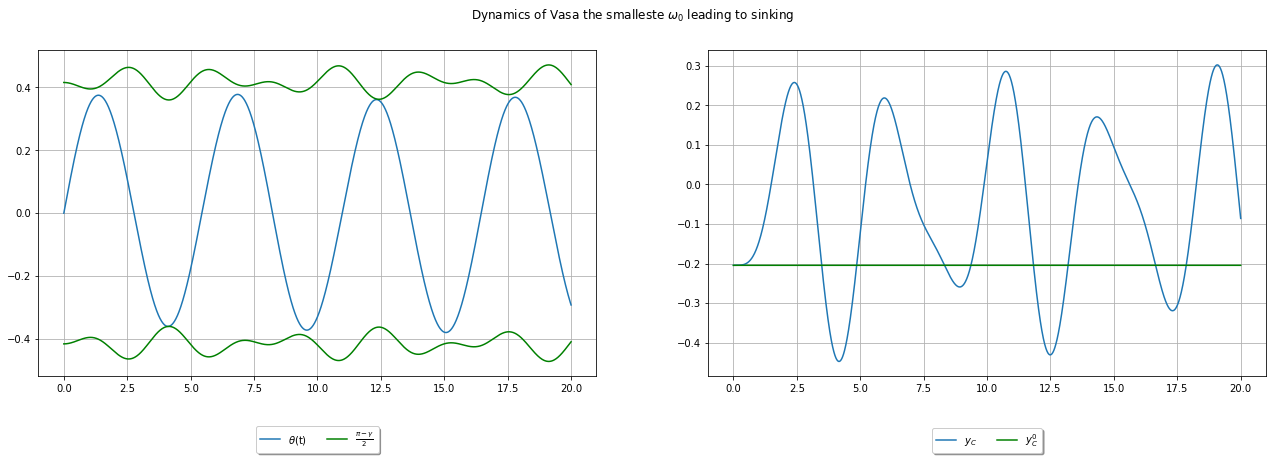

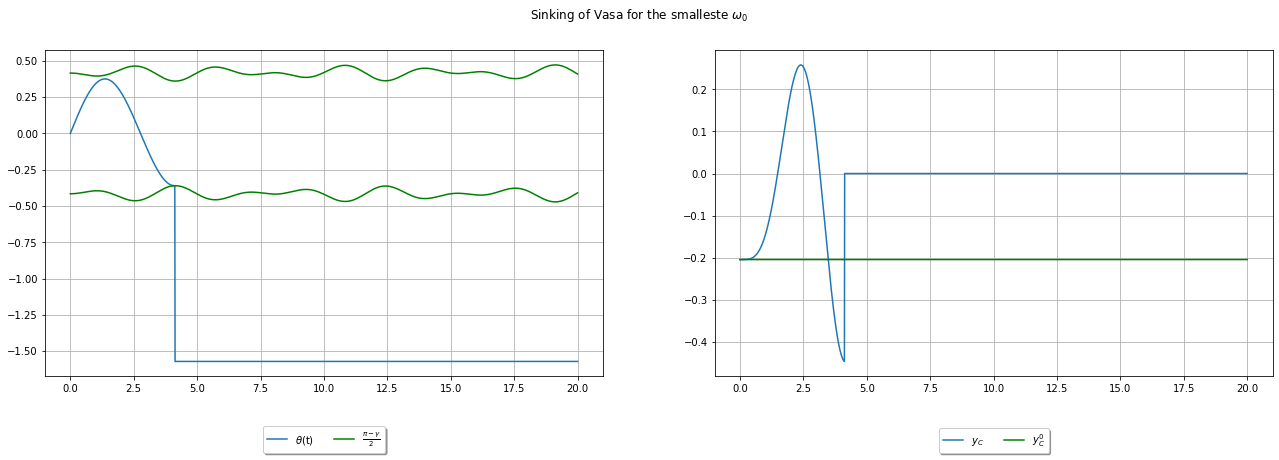

In [190]:
omega0 = 0.431548
tend = 20

t, omega_vec_sink = ode_solver(f2, t0, tend, np.array([theta0, omega0, 0, yc_0, 0, 0]), s, method = RK4, sinking = True)        #Omega vector for smallest omega_0, with sinking = True
t, omega_vec_not_sink = ode_solver(f2, t0, tend, np.array([theta0, omega0, 0, yc_0, 0, 0]), s, method = RK4)                    #Omega vector for smallest omega_0, with sinking = False

conditionFunc = condition(np.transpose(omega_vec_not_sink)[0], np.transpose(omega_vec_not_sink)[3] - yc_0)                      #Condition for sinking

#Plotting the instance without sinking + condition for sinking
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (22,6))
fig.suptitle(r'Dynamics of Vasa the smalleste $\omega_0$ leading to sinking')

ax1.plot(t, np.transpose(omega_vec_not_sink)[0], label = r'$\theta$(t)')
ax1.plot(t, conditionFunc, label = r'$\frac{\pi - \gamma}{2}$', color = "g")
ax1.plot(t, -conditionFunc, color = "g")

ax1.legend(loc = "lower center", bbox_to_anchor=(0.5, -0.25), ncol= 2, shadow = True)
ax1.grid()

ax2.plot(t, np.transpose(omega_vec_not_sink)[3], label = r'$y_C$')
ax2.plot(t, np.full(len(t), yc_0), label = r'$y_C^0$', color = "g" )

ax2.legend(loc = "lower center" , bbox_to_anchor=(0.5, -0.25), ncol= 2, shadow = True)
ax2.grid()

#Plotting instance with sinking + condition for sinking
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (22,6))
fig.suptitle(r'Sinking of Vasa for the smalleste $\omega_0$')

ax1.plot(t, np.transpose(omega_vec_sink)[0], label = r'$\theta$(t)')
ax1.plot(t, conditionFunc, label = r'$\frac{\pi - \gamma}{2}$', color = "g")
ax1.plot(t, -conditionFunc, color = "g")

ax1.legend(loc = "lower center", bbox_to_anchor=(0.5, -0.25), ncol= 2, shadow = True)
ax1.grid()

ax2.plot(t, np.transpose(omega_vec_sink)[3], label = r'$y_C$')
ax2.plot(t, np.full(len(t), yc_0), label = r'$y_C^0$', color = "g" )

ax2.legend(loc = "lower center" , bbox_to_anchor=(0.5, -0.25), ncol= 2, shadow = True)
ax2.grid()

The above plots illustrates at what instance Vasa is sinking when the smallest angular velocity, found above, is used as initial condition. The two plots at the top shows Vasa´s dynamics when the function isSinking is not being utalized, the bottommost plots shows the occurence of the sinking. The leftmost plots shows the angle $\theta$ as a function of time. Futhermore these plots contains the sinking condition $\frac{\pi - \gamma}{2}$ as a function of time.

It would be natural to assume the smallest $\omega_0$ corresponding to sinking, would have Vasa sinking at the last local minima/maxima of $\theta(t)$ for our given time span. As we can see, this is not the case. 
Since the sinking condition, $\theta > \frac{\pi - \gamma}{2}$, is a function of $\gamma = \gamma(\theta, y_c) = 2 \arccos\left[\cos \frac{\beta}{2} - \frac{4}{3\pi}(1 - \cos\theta) + \frac{\Delta y_c}{R}\right]$, not only the value of the angle $\theta$ impacts the sinking of Vasa, but also the vertical discplacement of the ship, $\Delta y_c$. Therefore, by a more thorough examination we would expect Vasa to capsize for a low value of $y_c$ and a larger value of $\theta$. 

Our bottommost plots shows this to be the case. We observe the instant Vasa is sinking to occure at the global minima of $y_c(t)$ in our domain and a local maxima for $|\theta(t)|$. These observations are in line with the above analysis.

**Mobile cargo**

It is natural for a ship of it's size to carry some weighty cargo. This cargo may disturbe the stability of the ship. For simplicity, the friction between the cargo and the ground is neglected, making it's movement totally determined by it's gravitation and normal force, like this:

\begin{align}
\sum{F} = -m_l g \sin\theta 
\end{align}

Moreover, the cargo will be a point mass placed on the ship deck. The inclusion of such a point mass will influence other proparties, i.e. $\beta$, $A_0$ etc. Furthermore, the load will present another set of forces affecting the ship:

\begin{aligned}
&F_{L}^{y}=-m_{L} g \cos ^{2} \theta \\
&F_{L}^{x}=m_{L} g \cos \theta \sin \theta
\end{aligned}

These forces further result in the following addition to the torque affecting Vasa:

\begin{aligned}
\tau_{L}=-m_{L} g \cos (\theta) s_{L}
\end{aligned}

In [191]:
#Corrected properties
m_l = 0.001 * m
 
#finding beta with cargo
sigma_l = sigma + m_l / A_s

def g_beta_l(beta):
    return np.pi * sigma_l / sigma_0 + np.sin(beta)

beta_l, numberOfSteps_l = fixedpoint(g_beta_l)

#finding placement of center of mass at equilibrium with cargo 
yc_0_l = getYc(0, 0, beta_l)

In [192]:
#Newly introduced forces caused by the cargo
def getF_Ly(theta):                         
    return - m_l * g * np.cos(theta)**2

def getF_Lx(theta):
    return m_l * g * np.cos(theta) * np.sin(theta)

def getT_L(theta, s_l):
    return -m_l * g * np.cos(theta) * abs(s_l)

As before we need to modify $\vec{w}$ and our vector function $\vec{f}(t, \vec{w})$ to be able to use our implementation of RK4. This time $\vec{f}(t, \vec{w})$ must be expanded to include both the position, $s_l$, and the velocity, $v_l$, of the cargo. Furthermore, our implementation must consider the situation in which $s_l > \pm R$, if such a situation occures the cargo leavs the edge of the ship and no longer affect the dynamics of Vasa.    

In [193]:
def f_l(t, omega_vec, yc_0 = yc_0):
    gamma = getGamma(omega_vec[0], omega_vec[3] - yc_0)

    #forces in y direction on Vasa
    F_B = getF_B(gamma)
    F_G = getF_G(m_l)
    F_Ly = getF_Ly(omega_vec[0])

    #forces in x direction on Vasa
    F_Lx = getF_Lx(omega_vec[0])

    #forces on load
    F_l = - m_l * g * np.sin(omega_vec[0])

    sumT = getT_B(omega_vec[0], F_B) + getT_L(omega_vec[0], omega_vec[6])       #net tourqe
    
    d_omega = sumT / (I_C + omega_vec[6] ** 2 * m_l)        # Using Parallel axis theorem to get correct moment of inertia

    a_x = F_Lx / (m + m_l)                                  #newtons second law in x direction to get a_x
    a_y = (F_B + F_G + F_Ly) / (m + m_l)                    #newtons second law in y direction to get a_y

    if cargo == True:                                       #Checking if cargo is on board
        a_l = F_l / m_l
        return np.array([omega_vec[1], d_omega, omega_vec[4], omega_vec[5], a_x, a_y, omega_vec[7], a_l])
    else:
        return np.array([omega_vec[1], d_omega, omega_vec[4], omega_vec[5], a_x, a_y, 0, 0])

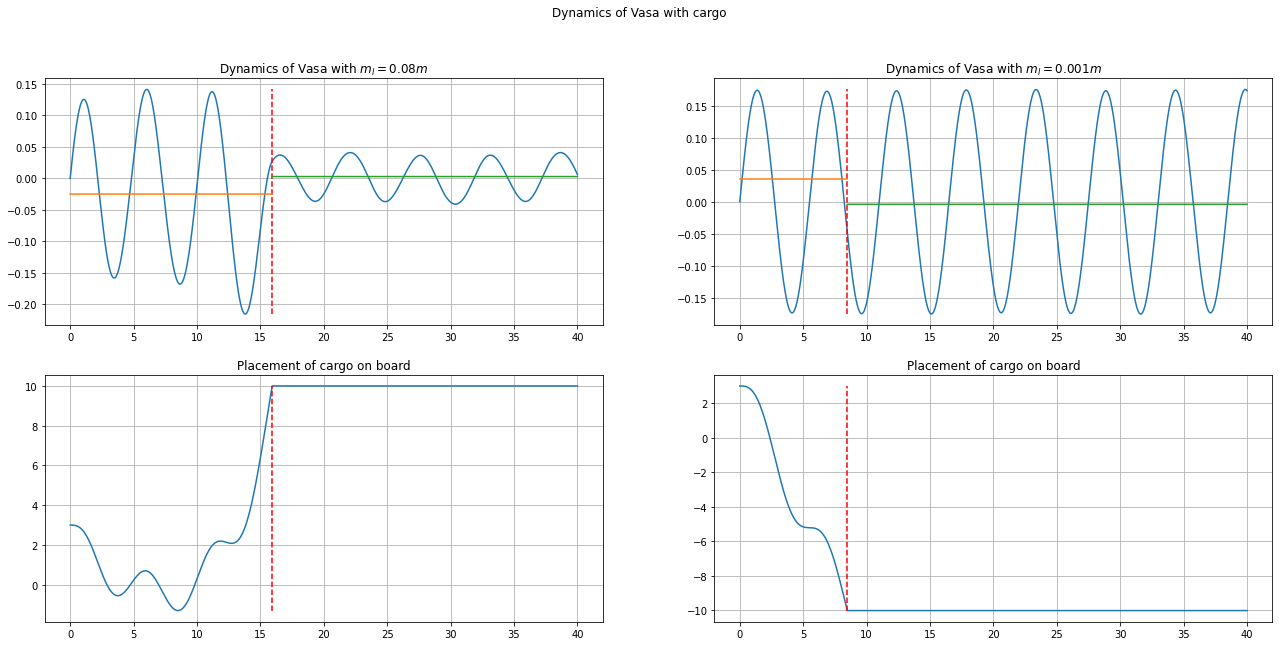

In [194]:
#Plotting dynamics of Vasa with cargo
masses = [0.08, 0.001]

t0 = 0
tend = 40

s_l0 = 3
v_l = 0

theta0 = 0
omega0 = 0.2

s = 0.01

fig, ax = plt.subplots(2, 2)
fig.set_figheight(10)
fig.set_figwidth(22)
fig.suptitle('Dynamics of Vasa with cargo')

for i in range(len(masses)):
    cargo = True
    m_l = masses[i] * m
    sigma_l = sigma + m_l / A_s
    beta_l, numberOfSteps_l = fixedpoint(g_beta_l)
    yc_0 = getYc(0, 0, beta_l)

    omega_vec_initial = np.array([theta0, omega0, 0, yc_0, 0, 0, s_l0, v_l])
    t, omega_vec = ode_solver(f_l, t0, tend, omega_vec_initial, s, method = RK4, sinking = True, load = True)

    s_l = np.transpose(omega_vec)[6]
    theta = np.transpose(omega_vec)[0]

    index_t_drop = np.argmax(abs(s_l) > R)
    t_drop = index_t_drop * s

    mean_with_load = np.full(index_t_drop, np.mean(theta[:index_t_drop]))
    mean_without_load = np.full(len(t[index_t_drop: len(t)]), np.mean(theta[index_t_drop:]))

    ax[0,i].plot(t, theta)
    ax[0,i].set_title(f'Dynamics of Vasa with $m_l = {masses[i]}m$')
    ax[0,i].vlines([t_drop], np.min(np.transpose(omega_vec)[0]), np.max(np.transpose(omega_vec)[0]) , linestyles='dashed', colors='red')
    ax[0,i].plot(t[:index_t_drop], mean_with_load)
    ax[0,i].plot(t[index_t_drop: len(t)], mean_without_load)
    ax[0,i].grid()

    ax[1,i].plot(t, s_l)
    ax[1,i].set_title(r'Placement of cargo on board')
    ax[1,i].vlines([t_drop], np.min(np.transpose(omega_vec)[6]), np.max(np.transpose(omega_vec)[6]) , linestyles='dashed', colors='red')
    ax[1,i].grid()


The two top graphs illustrates the angular displacement of $\theta$, with a red line to show where the cargo falls overboard, and two equilibrium lines, or more precisily average lines, before and after cargo fall. 

The corresponding bottom graphs illustrates the $x$-axis value of the cargo. keep in mind that this is the cargo's axis and not the ship's axis. Positive values too the right. 

We have choosen the spawn point of the mass to be $3$ meter right of the center, $\theta_0 = 0$, $\omega_0 = 0.2$ and caro masss to be $0.08m$ and $0.001m$ respectivly. 

In our top graphs, we see how the ship will resume its oscillation after the cargo falls overboard. In our top left graph, the cargo is falling off on the way up. Usually The down force contribution from the cargo, which is quite heavy in this case, will push the ship back down. However, since it's gone, the ship won't be pushed down as much, making a low amplitude. On the top right, we have a light cargo which won't effect the ship too much. The ship wobbling will make the lose cargo fall. We observe a small change in where it "equilibrium line"(average line), but it's amplitude will remain since the cargo force will be negligible. We also see that a heavier mass will remain longer on the ship, atleast for our initial conditions. The lesser mass wont effect the ship's dynamics and roll off to the left, while the larger mass will fight, making the ship very unstable before falling. 

**Sticky fences**

Late into the timeline of this project, we found some ambiguity in the assignment text. When it says that the cargo "stays" on the edge (forblir ved kanten). We assumes the fences sticky meaning after direct contact between the cargo and the edge, the cargo will stay put regardless of any extrenal force. We are aware of the unrealisitc behavior, but due to the late revelation, we stuck to this model. 

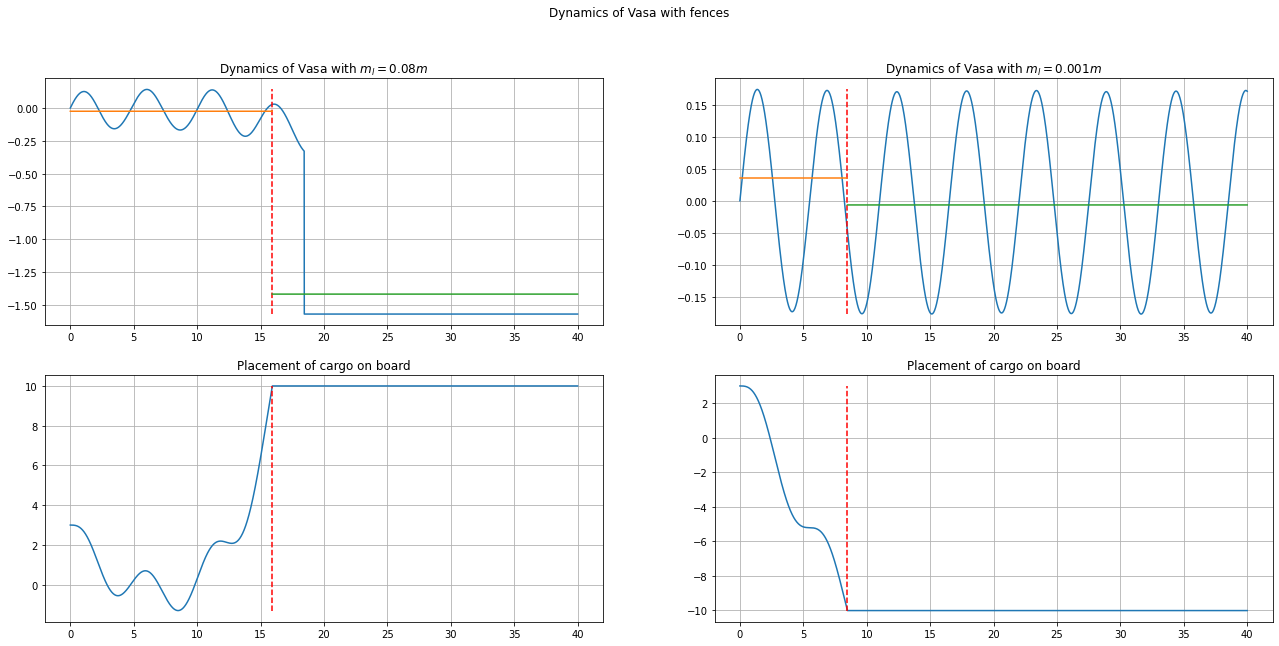

In [195]:
#Plotting the same as the above plots, now only with fences 
fig, ax = plt.subplots(2, 2)
fig.set_figheight(10)
fig.set_figwidth(22)
fig.suptitle('Dynamics of Vasa with fences')

for i in range(len(masses)):
    cargo = True
    m_l = masses[i] * m
    sigma_l = sigma + m_l / A_s
    beta_l, numberOfSteps_l = fixedpoint(g_beta_l)
    yc_0 = getYc(0, 0, beta_l)

    omega_vec_initial = np.array([theta0, omega0, 0, yc_0, 0, 0, s_l0, v_l])
    t, omega_vec = ode_solver(f_l, t0, tend, omega_vec_initial, s, method = RK4, sinking = True, load = True, fence = True)

    s_l = np.transpose(omega_vec)[6]
    theta = np.transpose(omega_vec)[0]

    index_t_drop = np.argmax(abs(s_l) > R)
    t_drop = index_t_drop * s

    mean_with_load = np.full(index_t_drop, np.mean(theta[:index_t_drop]))
    mean_without_load = np.full(len(t[index_t_drop: len(t)]), np.mean(theta[index_t_drop:]))

    ax[0,i].plot(t, theta)
    ax[0,i].set_title(f'Dynamics of Vasa with $m_l = {masses[i]}m$')
    ax[0,i].vlines([t_drop], np.min(np.transpose(omega_vec)[0]), np.max(np.transpose(omega_vec)[0]) , linestyles='dashed', colors='red')
    ax[0,i].plot(t[:index_t_drop], mean_with_load)
    ax[0,i].plot(t[index_t_drop: len(t)], mean_without_load)
    ax[0,i].grid()

    ax[1,i].plot(t, s_l)
    ax[1,i].set_title(r'Placement of cargo on board')
    ax[1,i].vlines([t_drop], np.min(np.transpose(omega_vec)[6]), np.max(np.transpose(omega_vec)[6]) , linestyles='dashed', colors='red')
    ax[1,i].grid()


Since the initial conditions are the same as earlier, the cargo will act the same as before until the red line is reached. When the cargo sticks to the fence, one side of the ship will be heavier then the other, making the ship have a "tilted oscillation". 

In the rightmost case, where $m_l = 0.001 m$, the mass of the cargo can as before be neglected, in the sense that it will not affect the oscillation of Vasa in any noticable way. In the case of the heavier mass, i.e. $m_l = 0.08 m$, Vasa careens immediatly after the cargo reaches the fence. Furthermroe, this careening quickly leads to the capsizing of the ship. By animations of our model, we observe the local minima of the displacement of the center of mass to be quite low, as a result of the added weight of the cargo, this in combination with the tilted oscillation leads to the sinking of the Swedish warship.

**Friction, waves and wind forces**

To approach a realistic environment to Vasa, we add friction forces between the ship's hull and the water. We assume a friction force proportional with the area of the ships interface with water:

$$f=-k_f R \gamma \omega (x)$$

$$\tau_w = F_w y_C$$

In addition we assume forces from wind and waves with harmonious horizontally directed force:

$$F_w = F_0 \cos{\omega_w} t (x)$$


$$\tau_f = f(y_C - (R(\cos({\gamma/2}))-1))$$


**Small comment on $sgn(\tau_f)$**

The torque is defined as a vector product between $r$ and $F_f$ in that order, since vector product is anti commutative, we need to be careful with the order. The friction force, will be right angle leg, meaning the the angel inbetween will be $2 \pi - \theta_f$. by the identity $\sin(2\pi-\alpha) = -\sin(\alpha)$ and the fact that $\vec r \times \vec F = |r||f|\sin(\alpha)$ we will get an extra minus in the the torque from the friction. 

In [196]:
#Introducing new forces, described above
def getFriction(gamma, omega):
    return - k_f * R * gamma * omega

def getF_w(t):
    return F_0 * np.cos(omega_w * t)

def getT_w(F_w, yc):
    return F_w * yc

def getT_f(f, gamma, yc):
    return -f * (yc - (R * np.cos(gamma/2) - 1))

In [197]:
#Updated f with added friction, wave and wind without cargo
def f_w(t, omega_vec, yc_0 = yc_0):
    gamma = getGamma(omega_vec[0], omega_vec[3] - yc_0, beta)

    #forces in y direction on Vasa
    F_B = getF_B(gamma)
    F_G = getF_G()

    #forces in x direction on Vasa
    F_w = getF_w(t)
    friction = getFriction(gamma, omega_vec[1])

    sumT = getT_B(omega_vec[0], F_B) + getT_w(F_w, omega_vec[3]) + getT_f(friction, gamma, omega_vec[3])
    
    d_omega = sumT / I_C

    a_x = (F_w + friction) / m
    a_y = (F_B + F_G) / m

    return np.array([omega_vec[1], d_omega, omega_vec[4], omega_vec[5], a_x, a_y])

#Updated f with added friction, wave and wind
def f_w2(t, omega_vec, yc_0 = yc_0):
    gamma = getGamma(omega_vec[0], omega_vec[3] - yc_0)

    #forces in y direction on Vasa
    F_B = getF_B(gamma)
    F_G = getF_G(m_l)
    F_Ly = getF_Ly(omega_vec[0])

    #forces in x direction on Vasa
    F_Lx = getF_Lx(omega_vec[0])
    F_w = getF_w(t)
    friction = getFriction(gamma, omega_vec[1])
    
    #forces on load
    F_l = - m_l * g * np.sin(omega_vec[0])

    sumT = getT_B(omega_vec[0], F_B) + getT_L(omega_vec[0], omega_vec[6]) + getT_w(F_w, omega_vec[3]) + getT_f(friction, gamma, omega_vec[3])
    
    d_omega = sumT / I_C

    a_x = (F_Lx + F_w + friction) / (m + m_l)
    a_y = (F_B + F_G + F_Ly) / (m + m_l)

    if cargo == True and m_l != 0:
        a_l = F_l / m_l
        return np.array([omega_vec[1], d_omega, omega_vec[4], omega_vec[5], a_x, a_y, omega_vec[7], a_l])
    else:
        return np.array([omega_vec[1], d_omega, omega_vec[4], omega_vec[5], a_x, a_y, 0, 0])

In [198]:
#Initial values and parameters with cargo
t0 = 0
tend = 40

m_l = 0        # mass of cargo
s_l0 = 0       # density of cargo
v_l = 0        # velocity of cargo
k_f = 1        # friction coefficient[kg/s^2]
omega_w = 1    # angular velocity of forces from wind and waves
F_0 = 0        # amplitude of forces from wind and waves
cargo = True   # if cargo onboard

theta0 = 0     # initial angle
omega0 = 0.4   # initial angular velocity

beta, numberOfSteps = fixedpoint(gBeta) # angle in contact with watersurface

yc_0 = getYc(0, 0, beta_l) # height of C above sea level

s = 0.01       # stepsize

# inital omega vector
omega_vec_initial = np.array([theta0, omega0, 0, yc_0, 0, 0, s_l0, v_l])

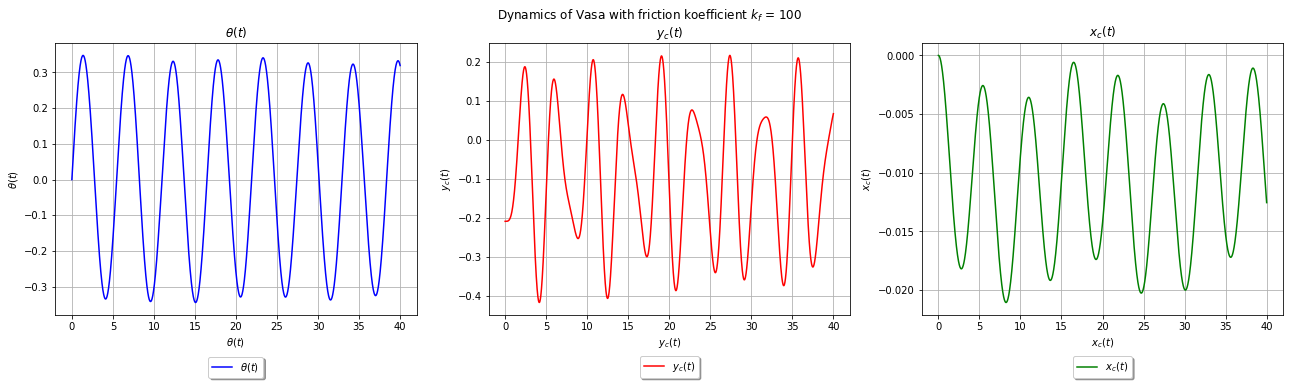

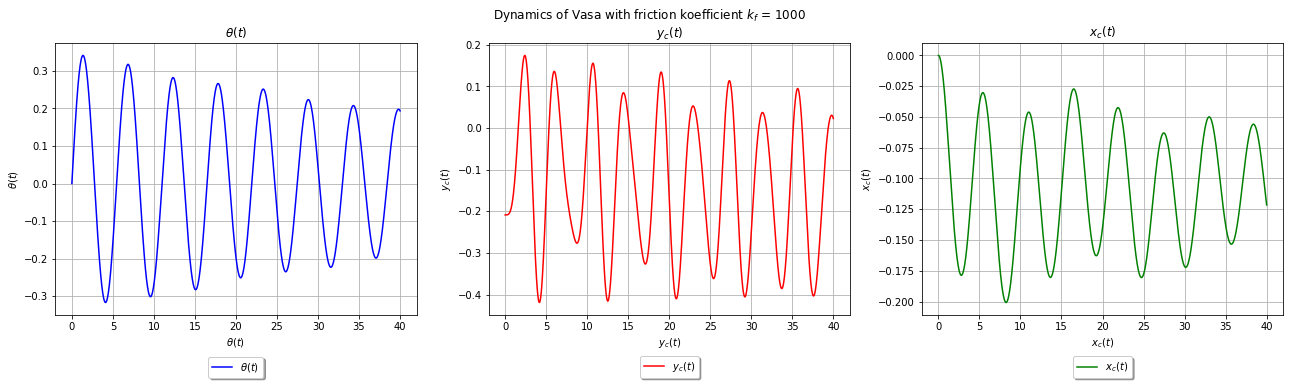

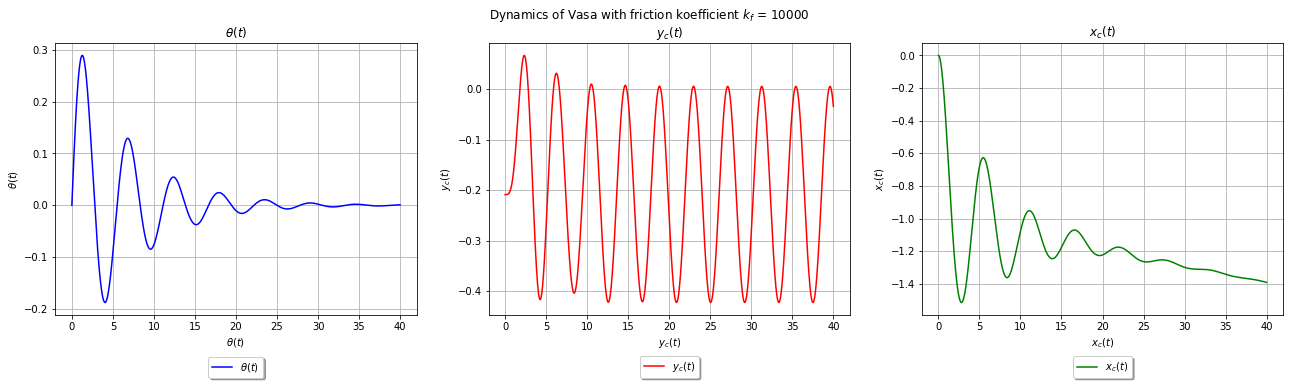

In [199]:
#Soling ODE for different k_f
k_f_array = [100, 1000, 10000]
for k_f in k_f_array:
    t_w, omega_vec_w = ode_solver(f_w2, t0, tend, omega_vec_initial, s, method = RK4)
    fig, axs = plt.subplots(1,3, figsize = (22,5))
    fig.suptitle(f'Dynamics of Vasa with friction koefficient $k_f$ = {k_f}')

    labels = [r'$\theta(t)$', r'$y_c(t)$', r'$x_c(t)$']
    ind = [0, 3, 2]
    colors = ['b', 'r', 'g']

    for i in range(len(axs)):
        axs[i].plot(t_w, np.transpose(omega_vec_w)[ind[i]], '-', label = labels[i], color = colors[i])
        axs[i].set_title(labels[i])
        axs[i].set_ylabel(labels[i])
        axs[i].set_xlabel(labels[i])
        axs[i].legend(loc = "lower center", bbox_to_anchor=(0.5, -0.25), ncol= 2, shadow = True)
        axs[i].grid()

The above plots show how higher order of magnitude for the fricton koefficient affect the oscilliation of Vasa. By inspection we observe the expected occurence of dampening of the system. The friction force contributes in dampening the oscillation, and higher orders of magnitude provied a larger such effect. 

In the case where the friction koefficient is large enough to make the ship stop oscillating, i.e. $k_f = 10000$, we observe the occurance of more stabile harmonic oscillations for both $y_c(t)$.

In [200]:
k_f_array = np.linspace(0, 1000, 11)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


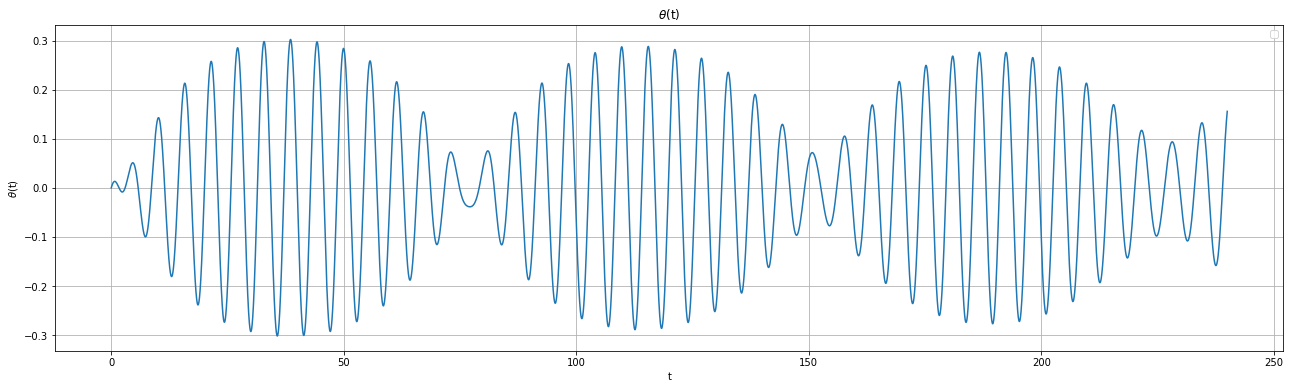

In [201]:
#Initial values and parameters
t0 = 0
tend = 240

theta0 = 0                    # initial angle
omega0 = np.radians(2)        # initial angular velocity

k_f = 100                     # friction coefficient[kg/s^2]
F_0 = 0.625 * m * g               # amplitude of forces from wind and waves
omega_w = 0.93 * omega_prime   # angular velocity of forces from wind and waves

beta, numberOfSteps = fixedpoint(gBeta) # angle in contact with watersurface

yc_0 = getYc(theta0, 0, beta)      # height of C above sea level

s = 0.01                      # stepsize

omega_vec_initial = np.array([theta0, omega0, 0, yc_0, 0, 0])
t_beat, omega_vec_beat = ode_solver(f_w, t0, tend, omega_vec_initial, s, method = RK4)

#plotting theta and a beat wave
plt.figure(figsize = (22,6))
plt.plot(t_beat, np.transpose(omega_vec_beat)[0])
plt.title(r'$\theta$(t) for harmonic force with frequency close to eigenfrecuency')
plt.ylabel(r'$\theta$(t)')
plt.xlabel(r't')
plt.grid()
plt.show()

We notice a beat wave, which appears when the frequency of the harmonical force from wind and waves is close to the natural frequency of the system:

$$\omega_0 = \sqrt{mgh/I_c}$$

Since the total torque of the system is not harmonical, the beat wave will change after time. We observe this in the plot, where the crossings are getting larger for bigger t.

**Implementation of additional ODE solvers**

We will now add two more ODE solvers and compare with the RK4 method. These are the Dormand-Prince(RKDP) method and Bogacki-Shampine(RKBS) method, and we will also implement an adaptive ODE solver. The Dormand-Prince method is a fourth and fifth order approximation, and the difference is used to implement an adaptive step size. The Bogacki-Shampine method is a second and third order approximation, where the difference is also used for an adaptive step size.

Both of these methods has the FSAL property, and therefore only uses six and three function evaluations for RKDP and RKBS. This is computational time saving and we will therefore implement this in the adaptive solver. RKBS method will therefore run faster comared to RK4, which uses four evaluations.

For low tolerance adaptive ODE solvers the RKBS method will use significant more time than the RPDP method because of lower order approximations. We will investigate this later on.

In [202]:
#Implementation of Dormand-Prince method
def RKDP(f, t, y, s, k_old=0, adaptive=False):
    a21 = 1/5
    a31, a32 = 3/40, 9/40
    a41, a42, a43 = 44/45, -56/15, 32/9
    a51, a52, a53, a54 = 19372/6561, -25360/2187, 64448/6561, -212/729
    a61, a62, a63, a64, a65 = 9017/3168, -355/33, 46732/5247, 49/176, -5103/18656
    a71, a72, a73, a74, a75, a76 = 35/384, 0, 500/1113, 125/192, -2187/6784, 11/84
    c2, c3, c4, c5, c6, c7 = 1/5, 3/10, 4/5, 8/9, 1, 1

    if t == 0:
        k1 = f(t, y)
    else:
        k1 = k_old
    k2 = f(t + c2 * s, y + s * a21 * k1)
    k3 = f(t + c3 * s, y + s * (a31 * k1 + a32 * k2))
    k4 = f(t + c4 * s, y + s * (a41 * k1 + a42 * k2 + a43 * k3))
    k5 = f(t + c5 * s, y + s * (a51 * k1 + a52 * k2 + a53 * k3 + a54 * k4))
    k6 = f(t + c6 * s, y + s * (a61 * k1 + a62 * k2 + a63 * k3 + a64 * k4 + a65 * k5))
    k7 = f(t + c7 * s, y + s * (a71 * k1 + a72 * k2 + a73 * k3 + a74 * k4 + a75 * k5 + a76 * k6))
    k = np.array([k1, k2, k3, k4, k5, k6, k7])

    B = np.array([35/384, 0, 500/1113, 125/192, -2187/6784, 11/84, 0])
    B2 = np.array([5179/57600, 0, 7571/16695, 393/640, -92097/339200, 187/2100, 1/40])

    y_next = y + s * B @ k
    t_next = t + s
    
    if adaptive:
        z_next = y + s * B2 @ k
        error_estimate = np.linalg.norm(z_next-y_next, 2)
        p = 5

        return t_next, y_next, error_estimate, p, k7
    else:
        return t_next, y_next, k7


In [203]:
#Implementation of Bogachi-Shampine method
def RKBS(f, t, y, s, k_old=0, adaptive=False, FSAL=False):
    if t == t0:
        k1 = f(t, y)
    else:
        k1 = k_old
    k2 = f(t + (1/2) * s, y + (1/2) * s * k1)
    k3 = f(t + (3/4) * s, y + (3/4) * s * k2)
    k = np.array([k1, k2, k3])
    
    B = np.array([2/9, 1/3, 4/9])
    B2 = np.array([7/24, 1/4, 1/3, 1/8])
    
    y_next = y + s * B @ k
    t_next = t + s
    
    k4 = f(t_next, y_next)
    
    if adaptive:
        k = np.array([k1, k2, k3, k4])
        z_next = y + s * B2 @ k
        error_estimate = np.linalg.norm(z_next-y_next)
        p = 3

        return t_next, y_next, error_estimate, p, k4
    else:
        return t_next, y_next, k4


In [204]:
#expanding our ode_solver to be adaptive
def ode_solver2(f, t0, tend, omega_vec_0, s, tol=1.e-10, method=RKBS, sinking=False, load=False, fence=False, adaptive=False):
    #Initializing:
    omega_vec_num = np.array([omega_vec_0])    # Array for the solution of omega_vec 
    t_num = np.array([t0])                     # Array for the t-values

    tn = t0                                    # Running values for t and array of omega_vec
    omega_vec_n = omega_vec_0

    # Main loop
    while tn < tend - 1.e-10:                  # Buffer for truncation errors
        if tn + s > tend:
            s = tend - tn

        if tn == 0:
            k_next = 0

        if sinking == True:
            if isSinking(omega_vec_n) == False:
                if adaptive:
                    tn_try, omega_vec_try, error_estimate, p, k_next = method(f, tn, omega_vec_n, s, k_next, adaptive=True)

                    if error_estimate <= tol:
                        omega_vec_n = omega_vec_try
                        tn = tn_try
                        omega_vec_num = np.concatenate((omega_vec_num, np.array([omega_vec_n])))
                        t_num = np.append(t_num,tn)
                else:
                    tn, omega_vec_n, k_next = method(f, tn, omega_vec_n, s, k_next)
                    omega_vec_num = np.concatenate((omega_vec_num, np.array([omega_vec_n])))
                    t_num = np.append(t_num,tn)

            elif isSinking(omega_vec_n) == True:
                if load == True:
                    omega_vec_n = [np.sign(omega_vec_n[0]) * np.pi/2, 0, 0, 0, 0, 0, omega_vec_n[6], 0]
                else:
                    omega_vec_n = [np.sign(omega_vec_n[0]) * np.pi/2, 0, 0, 0, 0, 0]
                    
                omega_vec_num = np.concatenate((omega_vec_num, np.array([omega_vec_n])))
                tn = tn + s
                t_num = np.append(t_num,tn)
            
            if load == True and fence == False:            
                if abs(omega_vec_n[6]) > R:
                    global cargo 
                    global m_l
                    cargo = False
                    m_l = 0
                    time = tn
            
            if load == True and fence == True:            
                if abs(omega_vec_n[6]) > R:
                    global Cargo
                    cargo = False
                    time = tn
                    
        else:
            if adaptive:
                tn_try, omega_vec_try, error_estimate, p, k_next = method(f, tn, omega_vec_n, s, k_next, adaptive=True)

                if error_estimate <= tol:
                    omega_vec_n = omega_vec_try
                    tn = tn_try
                    omega_vec_num = np.concatenate((omega_vec_num, np.array([omega_vec_n])))
                    t_num = np.append(t_num,tn)
            else:
                tn, omega_vec_n, k_next = method(f, tn, omega_vec_n, s, k_next)
                omega_vec_num = np.concatenate((omega_vec_num, np.array([omega_vec_n])))
                t_num = np.append(t_num,tn)
        
        if adaptive:
            s = 0.9*(tol/error_estimate)**(1/(p+1))*s
    
    return t_num, omega_vec_num


Bogacki-Shampine used 0.297 seconds
Runge-Kutta 4 used 0.279 seconds
Dormand-Prince used 0.473 seconds
Runge-Kutta 4 used 0.268 seconds
Bogacki-Shampine adaptive  4.994 seconds
Runge-Kutta 4  0.253 seconds
Dormand-Prince adaptive  0.13 seconds
Runge-Kutta 4  0.285 seconds


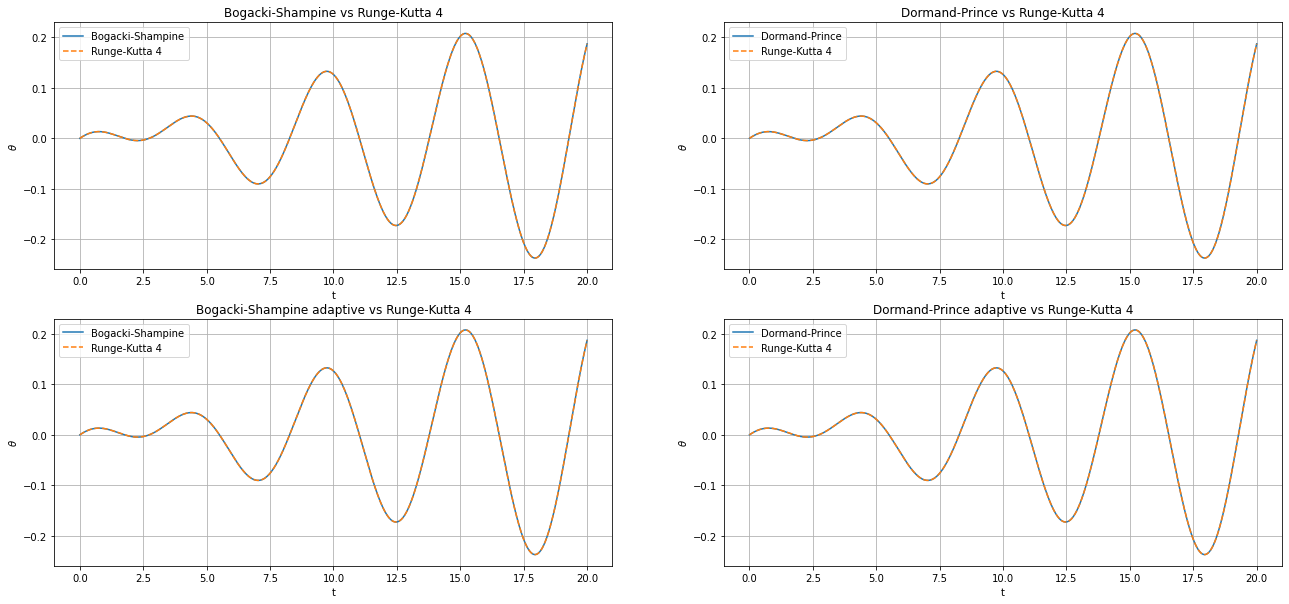

In [205]:
#Initial values and parameters
t0 = 0
tend = 20

theta0 = 0                    # initial angle
omega0 = np.radians(2)        # initial angular velocity

k_f = 100                     # friction coefficient[kg/s^2]
F_0 = 0.625 * m * g               # amplitude of forces from wind and waves
omega_w = omega_prime   # angular velocity of forces from wind and waves

beta, numberOfSteps = fixedpoint(gBeta) # angle in contact with watersurface

s = 0.01                      # stepsize

omega_vec_initial = np.array([theta0, omega0, 0, yc_0, 0, 0])

methods = [RKBS, RKDP]
labels = ["Bogacki-Shampine", "Dormand-Prince"]

#plotting RKBG vs RK4 and RKDP vs RK4 with and without adaptive property
fig, axs = plt.subplots(2,2, figsize = (22,5))
fig.set_figheight(10)
fig.set_figwidth(22)

for i in range(len(methods)):
    start_time = time.time()
    t, omega_vec = ode_solver2(f_w, t0, tend, omega_vec_initial, s, method=methods[i], sinking = True)
    mid_time = time.time()
    print(f"{labels[i]} used {round(mid_time - start_time,3)} seconds")
    t, omega_vec_RK4 = ode_solver(f_w, t0, tend, omega_vec_initial, s, method=RK4, sinking = True)
    end_time = time.time()
    print(f"Runge-Kutta 4 used {round(end_time - mid_time,3)} seconds")
    axs[0,i].plot(t, np.transpose(omega_vec)[0], label=labels[i])
    axs[0,i].plot(t, np.transpose(omega_vec_RK4)[0], '--', label="Runge-Kutta 4")
    axs[0,i].set_title(labels[i] + " vs Runge-Kutta 4")
    axs[0,i].set_ylabel(r"$\theta$")
    axs[0,i].set_xlabel("t")
    axs[0,i].legend()
    axs[0,i].grid()

for i in range(len(methods)):
    start_time = time.time()
    t, omega_vec = ode_solver2(f_w, t0, tend, omega_vec_initial, s, method=methods[i], sinking=True, adaptive=True)
    mid_time = time.time()
    print(f"{labels[i]} adaptive  {round(mid_time - start_time,3)} seconds")
    t_RK4, omega_vec_RK4 = ode_solver(f_w, t0, tend, omega_vec_initial, s, method=RK4, sinking=True)
    end_time = time.time()
    print(f"Runge-Kutta 4  {round(end_time - mid_time,3)} seconds")
    axs[1,i].plot(t, np.transpose(omega_vec)[0], label=labels[i])
    axs[1,i].plot(t_RK4, np.transpose(omega_vec_RK4)[0], '--', label="Runge-Kutta 4")
    axs[1,i].set_title(labels[i] + " adaptive" + " vs Runge-Kutta 4")
    axs[1,i].set_ylabel(r"$\theta$")
    axs[1,i].set_xlabel("t")
    axs[1,i].legend()
    axs[1,i].grid()


For a given step size $s$ and a time span $\mathcal{T} = \left[0, a\right]$ we make a discrete domain $\mathcal{T^\prime}$, with the same max and min values as $\mathcal{T}$, for our vector function $\vec{f}(t, \vec{w})$ with range $\mathcal{R}$. 

This yields the follwing:

\begin{aligned}
\mathcal{f} : \mathcal{T^\prime} \rightarrow \mathcal{R} \qquad \qquad \big|\mathcal{T^\prime}\big| = \frac{a}{s}
\end{aligned}

For a given ODE solver from the Runge-Kutta family, i.e. RK4, Dormand-Prince and Bogacki-Shampine, with $d$ function evaluations per step, the amount of function evaluations, $eval(s, a, d)$ for a given step size $s$ and time span $\mathcal{T} = \left[0, a\right]$, is given in the following way:

\begin{aligned}
eval(s, a, d) = d \big|\mathcal{T^\prime}\big| = d \frac{a}{s}
\end{aligned}

If FSAL is utilized the amount of evaluations is reduced to the following:

\begin{aligned}
eval_{FSAL}(s, a, d) = (d-1) \frac{a}{s} + 1
\end{aligned}

From the equations presented above, the ratio between the amount of function evaluations for Dormand-prince, which is without FSAL, and Bogacki-Shampine, which is utilizing FSAL, we get the following: 

\begin{aligned}
\frac{eval_{DP}(s, a, p)}{eval_{BS}(s, a, p^{\prime})} = \frac{p\frac{a}{s}}{(p^{\prime}-1) \frac{a^{\prime}}{s^{\prime}}} = \left(\frac{p^{\prime}}{p} - \frac{1}{p} + \frac{s}{pa}\right)^{-1} = \left(\frac{3}{7} - \frac{1}{7} + \frac{10^{-2}}{7 \cdot 20}\right)^{-1} = \frac{4001}{14000} \approx 3.499
\end{aligned}

From this we observe RKDP to do about 3.5 times more function evaluations than RKBS. This huge difference in calculations will obviously result in a difference in run time, which we see from the above data. 

For an adaptive step size the RKBS method is the slowest due to low order and high tolerance which will need smaller stepsizes, hence longer run time. The RKDP is the fastest as a result of a high order, and will therefore increase the stepsize, hence shorter run time.

**Error analysis of different methods**

Furthermore, we will investigate the error and order of the different methods

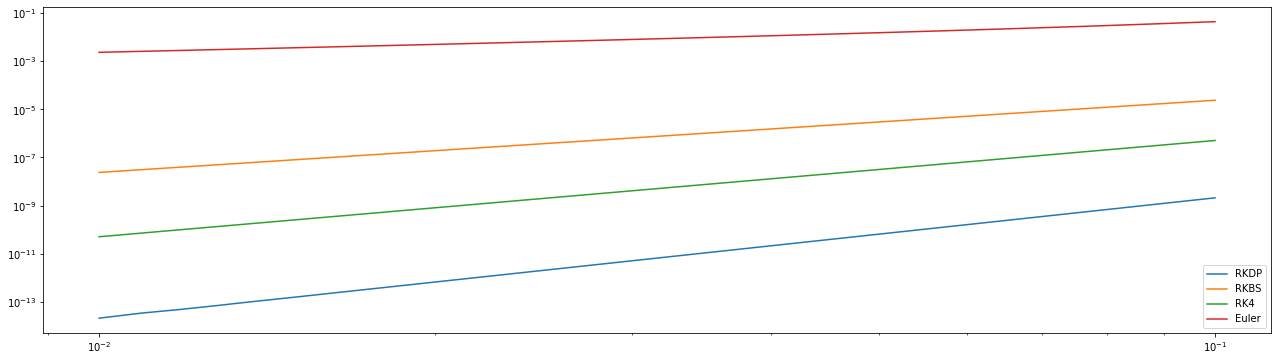

RKDP 5.0020764217068345
RKBS 3.001247635655687
RK4 4.001537323584974
Euler 1.2740711693055322


In [206]:
#Initial conditions
theta_0 = np.radians(1)
omega_0 = 0
t_0 = 0
t_end = 20
ss = np.linspace(0.01, 0.1, 100)

methods = [RKDP, RKBS, RK4, euler]
solvers = [ode_solver2, ode_solver2, ode_solver, ode_solver]
labels = ["RKDP", "RKBS", "RK4", "Euler"]
errors = np.zeros([len(methods), len(ss)])

#Plotting the error between analytic solution to numerical solution to ODE with small angle approximation 
for i in range(len(methods)):  
    for j in range(len(ss)):
        t, omega_vec = solvers[i](fSA, t_0, t_end, np.array([theta_0, omega_0]), ss[j], method=methods[i])   
        theta_analytical = thetaThilde(t, theta_0, omega_0)
        errors[i][j] = np.linalg.norm(np.transpose(omega_vec)[0] - theta_analytical,np.inf)

plt.figure(figsize = (22,6))
for i in range(len(methods)):
    plt.loglog(ss, errors[i], label=labels[i])
plt.legend()
plt.show()

for i in range(len(errors)):
    order = np.log10(errors[i][-1]/errors[i][0])
    print(labels[i],order)

This is consistent with our expectations. Eulers order is not equal to $1$ for the simple reason that the intervall $0.01$ to $0.1$ is too large for a first order approximation.
The RKDP adaptive method is therefore the best of these methods in both run time and error.

In [207]:
##Initial conditions
theta_0 = np.radians(1)
omega_0 = 0
t_0 = 0
t_end = 20
s = 0.01

methods = [RKDP, RKBS]
labels = ["RKDP","RKBS"]

for i in range(len(methods)):  
    t, omega_vec = ode_solver2(fSA, t_0, t_end, np.array([theta_0, omega_0]), ss[j], method=methods[i])   
    theta_analytical = thetaThilde(t, theta_0, omega_0)
    error = np.linalg.norm(np.transpose(omega_vec)[0]-theta_analytical,np.inf)
    print(labels[i], ": ", error)

for i in range(len(methods)):  
    t, omega_vec = ode_solver2(fSA, t_0, t_end, np.array([theta_0, omega_0]), ss[j], method=methods[i], adaptive=True)
    theta_analytical = thetaThilde(t, theta_0, omega_0)
    error = np.linalg.norm(np.transpose(omega_vec)[0]-theta_analytical,np.inf)
    print(labels[i], " adaptive:", error)

RKDP :  2.0885072768428437e-09
RKBS :  2.3838678305989486e-05
RKDP  adaptive: 3.794763739350948e-10
RKBS  adaptive: 2.7019949194739823e-09


**Stability** 

Further we will study the stability of the Vasa ship using RKDP and RK4 for comparison. We use the following initial condition:

\begin{aligned}
k_f = 1, \quad F_0 = 1 \cdot mg, \quad \theta(t=0) = 0, \quad \omega(t=0) = 0
\end{aligned}

We test different values for $\omega_w$ and find which value capsizes the ship fastest. We find it appropriate to look at the constant $\omega_w/\omega_0 = c$, such that $\omega_w = c\omega_0$

In [208]:
t0 = 0
tend = 100

theta0 = 0                    # initial angle
omega0 = np.radians(0)        # initial angular velocity

omega_vec_initial = np.array([theta0, omega0, 0, yc_0, 0, 0])

k_f = 1                     # friction coefficient[kg/s^2]
F_0 = 1 * m * g               # amplitude of forces from wind and waves

s = 0.01

omega_w_s_RK4 = np.linspace(1.01, 1.02, 201)
t_capsize_s_RK4 = np.zeros(len(omega_w_s_RK4))

for i in range(len(omega_w_s_RK4)):
    omega_w = omega_w_s_RK4[i] * omega_prime
    t, omega_vec = ode_solver(f_w, t0, tend, omega_vec_initial, s, method=RK4, sinking=True)
    gamma = getGamma(np.transpose(omega_vec)[0], np.transpose(omega_vec)[3] - yc_0)
    index_t = np.argmax(abs(np.transpose(omega_vec)[0]) > (np.pi - gamma)/2)
    t_capsize_s_RK4[i] = index_t * s

lowestT_RK4 = np.amin(t_capsize_s_RK4)
print("c =", omega_w_s_RK4[np.argwhere(t_capsize_s_RK4 == lowestT_RK4)][0])
print("c =", omega_w_s_RK4[np.argwhere(t_capsize_s_RK4 == lowestT_RK4)[-1]])

c = [1.0152]
c = [1.0177]


In [209]:
t0 = 0
tend = 100

theta0 = 0                    # initial angle
omega0 = np.radians(0)        # initial angular velocity

omega_vec_initial = np.array([theta0, omega0, 0, yc_0, 0, 0])

k_f = 1                     # friction coefficient[kg/s^2]
F_0 = 1 * m * g               # amplitude of forces from wind and waves

s = 0.01

omega_w_s_RKDP = np.linspace(1.01, 1.02, 201)
t_capsize_s_RKDP = np.zeros(len(omega_w_s_RKDP))

for i in range(len(omega_w_s_RKDP)):
    omega_w = omega_w_s_RKDP[i] * omega_prime
    t, omega_vec = ode_solver2(f_w, t0, tend, omega_vec_initial, s, method=RKDP, sinking=True)
    gamma = getGamma(np.transpose(omega_vec)[0], np.transpose(omega_vec)[3] - yc_0)
    index_t = np.argmax(abs(np.transpose(omega_vec)[0]) > (np.pi - gamma)/2)
    t_capsize_s_RKDP[i] = index_t * s

lowestT_RKDP = np.amin(t_capsize_s_RKDP)
print("c =", omega_w_s_RKDP[np.argwhere(t_capsize_s_RKDP == lowestT_RKDP)][0])
print("c =", omega_w_s_RKDP[np.argwhere(t_capsize_s_RKDP == lowestT_RKDP)[-1]])

c = [1.0152]
c = [1.0177]


C interval that gives shortest capsize time by RK4 = [(1.0152, 1.0177)]
C interval that gives shortest capsize time by RKDP = [(1.0152, 1.0177)]


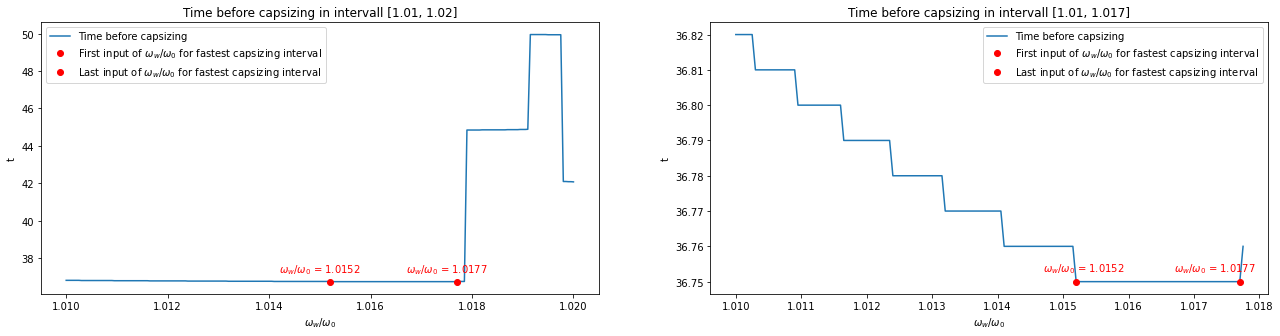

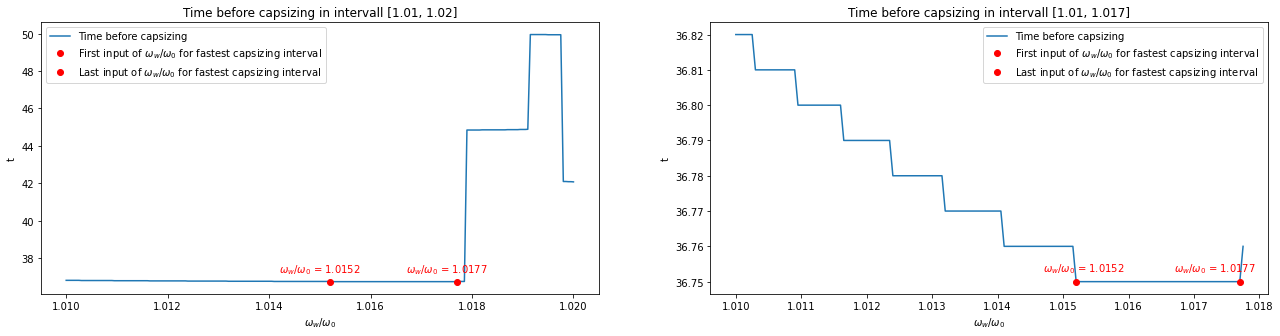

In [210]:
iOfEF_RK4 = np.argwhere(t_capsize_s_RK4 == lowestT_RK4)
iOfEF_RKDP = np.argwhere(t_capsize_s_RKDP == lowestT_RKDP)

fig, axs = plt.subplots(1,2, figsize = (22,5))
axs[0].set_title("Time before capsizing in intervall [1.01, 1.02]")
axs[0].plot(omega_w_s_RK4, t_capsize_s_RK4, label="Time before capsizing")
axs[0].plot(omega_w_s_RK4[np.argmin(t_capsize_s_RK4)], np.amin(t_capsize_s_RK4), 'o', label=r"First input of $\omega_w/\omega_0$ for fastest capsizing interval", color='r')
axs[0].plot(omega_w_s_RK4[iOfEF_RK4[-1][-1]], np.amin(t_capsize_s_RK4), 'o', label=r"Last input of $\omega_w/\omega_0$ for fastest capsizing interval", color='r')
axs[0].set_xlabel(r"$\omega_w / \omega_0$")
axs[0].set_ylabel("t")
axs[0].text(omega_w_s_RK4[np.argmin(t_capsize_s_RK4)]-0.001, np.amin(t_capsize_s_RK4)+0.5, f"$\omega_w/\omega_0$ = {omega_w_s_RK4[np.argmin(t_capsize_s_RK4)]}", color='r')
axs[0].text(omega_w_s_RK4[iOfEF_RK4[-1][-1]]-0.001, np.amin(t_capsize_s_RK4)+0.5, f"$\omega_w/\omega_0$ = {omega_w_s_RK4[iOfEF_RK4[-1][0]]}", color='r')
axs[0].legend()

axs[1].plot(omega_w_s_RK4[:156], t_capsize_s_RK4[:156], label="Time before capsizing")
axs[1].set_title("Time before capsizing in intervall [1.01, 1.017]")
axs[1].plot(omega_w_s_RK4[np.argmin(t_capsize_s_RK4)], np.amin(t_capsize_s_RK4), 'o', label=r"First input of $\omega_w/\omega_0$ for fastest capsizing interval", color='r')
axs[1].plot(omega_w_s_RK4[iOfEF_RK4[-1][-1]], np.amin(t_capsize_s_RK4), 'o', label=r"Last input of $\omega_w/\omega_0$ for fastest capsizing interval", color='r')
axs[1].set_xlabel(r"$\omega_w / \omega_0$")
axs[1].set_ylabel("t")
axs[1].text(omega_w_s_RK4[np.argmin(t_capsize_s_RK4)]-0.0005, np.amin(t_capsize_s_RK4)+0.003, f"$\omega_w/\omega_0$ = {omega_w_s_RK4[np.argmin(t_capsize_s_RK4)]}", color='r')
axs[1].text(omega_w_s_RK4[iOfEF_RK4[-1][-1]]-0.001, np.amin(t_capsize_s_RK4)+0.003, f"$\omega_w/\omega_0$ = {omega_w_s_RK4[iOfEF_RK4[-1][0]]}", color='r')
axs[1].legend()

print(f"C interval that gives shortest capsize time by RK4 = [{omega_w_s_RK4[iOfEF_RK4[0][0]], omega_w_s_RK4[iOfEF_RK4[-1][0]]}]")

fig, axs = plt.subplots(1,2, figsize = (22,5))
axs[0].set_title("Time before capsizing in intervall [1.01, 1.02]")
axs[0].plot(omega_w_s_RKDP, t_capsize_s_RKDP, label="Time before capsizing")
axs[0].plot(omega_w_s_RKDP[np.argmin(t_capsize_s_RKDP)], np.amin(t_capsize_s_RKDP), 'o', label=r"First input of $\omega_w/\omega_0$ for fastest capsizing interval", color='r')
axs[0].plot(omega_w_s_RKDP[iOfEF_RKDP[-1][-1]], np.amin(t_capsize_s_RKDP), 'o', label=r"Last input of $\omega_w/\omega_0$ for fastest capsizing interval", color='r')
axs[0].set_xlabel(r"$\omega_w / \omega_0$")
axs[0].set_ylabel("t")
axs[0].text(omega_w_s_RKDP[np.argmin(t_capsize_s_RKDP)]-0.001, np.amin(t_capsize_s_RKDP)+0.5, f"$\omega_w/\omega_0$ = {omega_w_s_RKDP[np.argmin(t_capsize_s_RKDP)]}", color='r')
axs[0].text(omega_w_s_RKDP[iOfEF_RKDP[-1][-1]]-0.001, np.amin(t_capsize_s_RKDP)+0.5, f"$\omega_w/\omega_0$ = {omega_w_s_RKDP[iOfEF_RKDP[-1][0]]}", color='r')
axs[0].legend()

axs[1].plot(omega_w_s_RKDP[:156], t_capsize_s_RKDP[:156], label="Time before capsizing")
axs[1].set_title("Time before capsizing in intervall [1.01, 1.017]")
axs[1].plot(omega_w_s_RKDP[np.argmin(t_capsize_s_RKDP)], np.amin(t_capsize_s_RKDP), 'o', label=r"First input of $\omega_w/\omega_0$ for fastest capsizing interval", color='r')
axs[1].plot(omega_w_s_RK4[iOfEF_RKDP[-1][-1]], np.amin(t_capsize_s_RKDP), 'o', label=r"Last input of $\omega_w/\omega_0$ for fastest capsizing interval", color='r')
axs[1].set_xlabel(r"$\omega_w / \omega_0$")
axs[1].set_ylabel("t")
axs[1].text(omega_w_s_RKDP[np.argmin(t_capsize_s_RKDP)]-0.0005, np.amin(t_capsize_s_RK4)+0.003, f"$\omega_w/\omega_0$ = {omega_w_s_RK4[np.argmin(t_capsize_s_RK4)]}", color='r')
axs[1].text(omega_w_s_RKDP[iOfEF_RKDP[-1][-1]]-0.001, np.amin(t_capsize_s_RKDP)+0.003, f"$\omega_w/\omega_0$ = {omega_w_s_RKDP[iOfEF_RKDP[-1][0]]}", color='r')
axs[1].legend()

print(f"C interval that gives shortest capsize time by RKDP = [{omega_w_s_RKDP[iOfEF_RKDP[0][0]], omega_w_s_RKDP[iOfEF_RKDP[-1][0]]}]")


The above plots shows the interval of $c = \frac{\omega}{\omega_0}$ for which Vasa is sinking the fastest. We see that even though Dormand-Prince has a higher order of precision, the values are the same. This makes us conclude that for our specific purpose and resolution, the higher order method will not be able to give us a more precise result even though the run time and amount of function evaluations is a lot greater than for RK4. 

Regarding the result: we would expect the sinking of Vasa to occure the fastets when $\omega_w$ is approching eigenfrequency of the system. Even though we are not able to derive a analytic value for this eigenfrequency, we would expect a value not far off the analytic eigenfrequency $\omega_0 = \sqrt{\frac{mgh}{I_C}}$ derived from the small angle approximation. As we can see by the plots above this seems to be the case, as the ship capsizes the fastest for $\omega_w = c \omega_0$ for $c \in \left[1.0152, 1.0177\right]$

**Capsizing for a low harmonical force**

In order to test this eigenfrequency in our model, we try a small amplitude $F_0 = 0.25 m g$, and friction coefficient $k_f = 1$ in the interval $t \in [0, 400]$, with $\omega_w = 1.0152\omega_0$

273.55
273.55


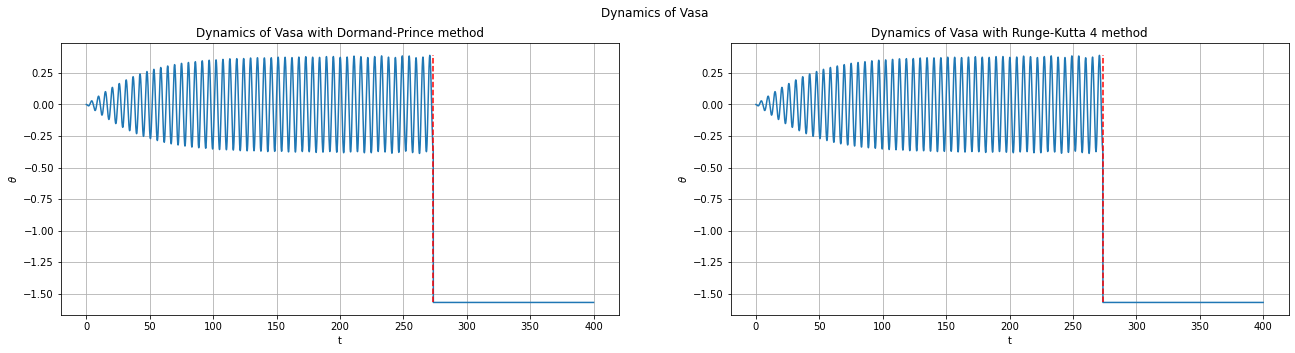

In [211]:
t0 = 0
tend = 400

theta0 = 0                    # initial angle
omega0 = np.radians(0)        # initial angular velocity

k_f =1                     # friction coefficient[kg/s^2]
F_0 = 0.25 * m * g               # amplitude of forces from wind and waves
omega_w = 1.0152 * omega_prime   # angular velocity of forces from wind and waves

s = 0.01

fig, ax = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(22)
fig.suptitle('Dynamics of Vasa')

methods = [RKDP, RK4]
labels = ["Dormand-Prince", "Runge-Kutta 4"]
solvers = [ode_solver2, ode_solver]
for i in range(len(methods)):

    omega_vec_initial = np.array([theta0, omega0, 0, yc_0, 0, 0])
    t, omega_vec = solvers[i](f_w, t0, tend, omega_vec_initial, s, method = methods[i], sinking=True)

    theta = np.transpose(omega_vec)[0]

    gamma = getGamma(np.transpose(omega_vec)[0], np.transpose(omega_vec)[3] - yc_0)
    index_t = np.argmax(abs(np.transpose(omega_vec)[0]) > (np.pi - gamma)/2)
    t_capsize = index_t * s
    print(t_capsize)

    ax[i].plot(t, theta)
    ax[i].set_title(f'Dynamics of Vasa with {labels[i]} method')
    ax[i].vlines([t_capsize], np.min(np.transpose(omega_vec)[0]), np.max(np.transpose(omega_vec)[0]) , linestyles='dashed', colors='red')
    ax[i].set_xlabel("t")
    ax[i].set_ylabel(r"$\theta$")
    ax[i].grid()

We notice that even for a small harmonical force, the ship capsizes with just the correct frequency $\omega_w$. This is important to keep in mind when testing the ships stability.

**Conclusion**

During the above analysis of the swedish historical ship Vasa, which sank in 1628, we have utilized a range of different numerical technics to study its dynamics for different scenarios. Our examination of this historical event has been done by examining the ship modeled as a semicircle. 

During the course of the project the system has evolved, through inclusion of additional ascpects, to a rather complex model. Initialy the model considered gravity and buoyancy as the only forces affecting the ship. From this initial analysis, we have successfully examined the system as new aspects has been added to our model, i.e. added cargo, wind and waves and friction. This analysis has been executed with the use of different numerical ODE-solvers, i.e. Runge-Kutta methods and eulers method. We have seen how changing the initial conditions, i.e. $\theta_0$ and $\omega_0$, has played a huge impact on the behaviour of our model. 

In the latter parts of the project we have compaired three different ODE solvers from the Runge-Kutta family. We have examined methods of different order and observed how higher order methods demand a longer run time than the ones of lower order. In the end we used the fifth order method Runge-Kutta Dormand Prince and the fourth order method Runge-Kutta 4 to numericaly approximate the eigenfrequancy of the system, and compairing the results of the two methods. Given our degree of resolution we concluded that the higher run time and precision of the non adaptive RKDP does not affect the results in any meaningfull way. 